# 1. LSTM without hyperparameter optimisation

## 1.1 Importing libraries

In [16]:
### Import Libraries
import numpy as np
import pandas as pd
import sklearn
import optuna
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional, TimeDistributed, Reshape, Layer
from tensorflow.keras.layers import RNN
import math
import time
import yfinance as yf


# hide warnings for a cleaner notebook:
import warnings
warnings.filterwarnings('ignore')



## 1.2 Printing environment versions

**1.2.1 Environment variables**

In [6]:
import platform
import sys
import os
import psutil
import tensorflow as tf

def system_info():
    # Python version
    print("Python Version:", sys.version)
    print("Operating System:", platform.system(), platform.release(), platform.version())
    print("CPU:", platform.processor())
    print("CPU Cores:", os.cpu_count())
    print("RAM Size:", round(psutil.virtual_memory().total / (1024 ** 3), 2), "GB")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            print("GPU:", gpu.name)
    else:
        print("No GPU available.")

system_info()

Python Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Operating System: Windows 11 10.0.22631
CPU: Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU Cores: 8
RAM Size: 47.88 GB
No GPU available.


**1.2.2 Libraries versions**

It is good practice to identify the version of libraries and system environment. This is done for the purpose of compatibility and reproducibility.

In [14]:
print("Numpy version -> ",np.__version__)
print("Pandas version -> ",pd.__version__)
print("Tensorflow version -> ",tf.__version__)
print("Scikit-learn version -> ", sklearn.__version__)
print("Optuna version -> ", optuna.__version__)
print("Matplotlib version ->",matplotlib.__version__)
print("yfinance version ->",yf.__version__)



Numpy version ->  1.26.4
Pandas version ->  2.2.2
Tensorflow version ->  2.18.0
Scikit-learn version ->  1.4.2
Optuna version ->  4.1.0
Matplotlib version -> 3.8.4
yfinance version -> 0.2.50


## 1.3 Download and prepare dataset

**1. Data exploration**

This notebook analyzes historical stock data for five major companies: Apple (AAPL), Microsoft (MSFT), Google (GOOGL), Amazon (AMZN), and Tesla (TSLA). The data covers the period from January 1, 2021, to December 31, 2023. The analysis begins with data download using the `yfinance` library, which retrieves historical stock prices including Open, High, Low, Close, Volume, and Adjusted Close prices. 

Next, the dataset is cleaned by removing missing values to ensure consistency and readiness for analysis. The exploration phase involves generating summary statistics such as mean, median, and standard deviation to understand the dataset better. Trends in stock prices over time are visualized through a line chart of Adjusted Close prices, providing insights into the stock market performance during the specified periodlow.

[*********************100%***********************]  5 of 5 completed


Initial data preview:
Price        Adj Close                                                 \
Ticker            AAPL        AMZN      GOOGL        MSFT        TSLA   
Date                                                                    
2021-01-04  126.544205  159.331497  85.994766  210.423126  243.256668   
2021-01-05  128.108780  160.925507  86.688248  210.626068  245.036667   
2021-01-06  123.796432  156.919006  85.832840  205.164658  251.993332   
2021-01-07  128.020782  158.108002  88.396561  211.003082  272.013336   
2021-01-08  129.125778  159.134995  89.566811  212.288681  293.339996   

Price            Close                                                 ...  \
Ticker            AAPL        AMZN      GOOGL        MSFT        TSLA  ...   
Date                                                                   ...   
2021-01-04  129.410004  159.331497  86.306503  217.690002  243.256668  ...   
2021-01-05  131.009995  160.925507  87.002502  217.899994  245.036667  ...   
202

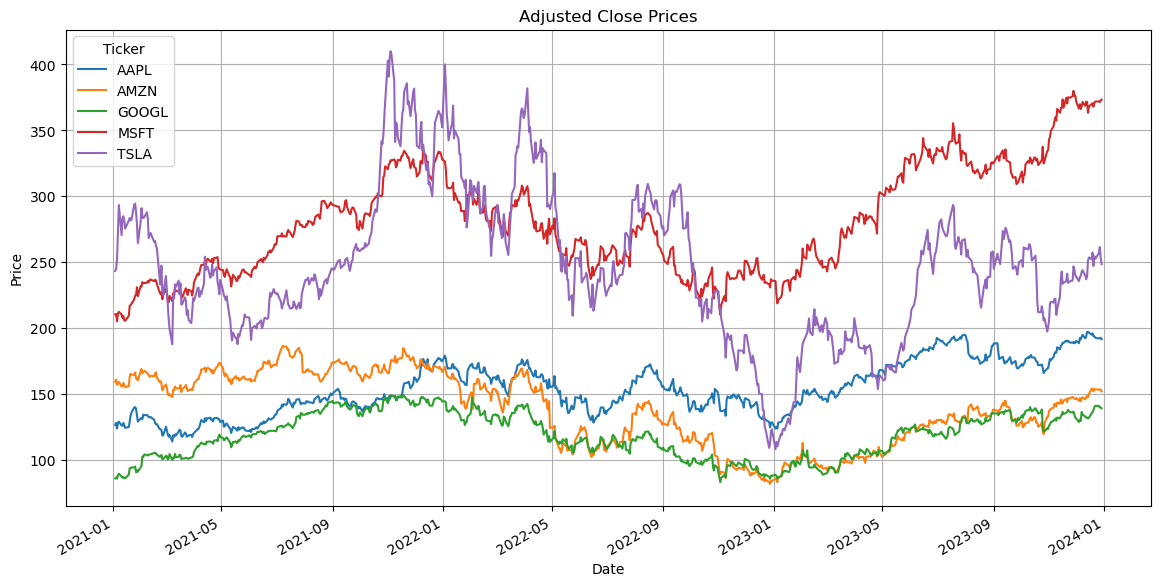

In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the tickers and time period
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
start_date = "2021-01-01"
end_date = "2023-12-31"

# Download data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the data
print("Initial data preview:")
print(data.head())

# Data Cleaning
# Remove rows with missing values
cleaned_data = data.dropna()

# Display information about cleaned data
print("\nCleaned data info:")
cleaned_data.info()

# Data Exploration
# Summary statistics
print("\nSummary statistics:")
print(cleaned_data.describe())

# Plot Adjusted Close Prices
print("\nPlotting Adjusted Close Prices...")
cleaned_data['Adj Close'].plot(figsize=(14, 7), title='Adjusted Close Prices', grid=True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()




The *download_data()* function fetches historical stock data for the specified tickers from Yahoo Finance using the yfinance library. 

In [12]:
def download_data(tickers, start, end):
    data = []
    for ticker_symbol in tickers:  # Renamed ticker to ticker_symbol to avoid conflicts
        df = yf.download(ticker_symbol, start=start, end=end)[["Close"]]
        df = df.rename(columns={"Close": ticker_symbol})  # Fixed renaming for Series
        data.append(df)
    if not data:
        raise ValueError("No valid data retrieved for the provided tickers.")
    combined_data = pd.concat(data, axis=1).dropna()
    return combined_data

The *preprocess_data(data)* function scales the input data (typically stock prices) to a range between 0 and 1 using the MinMaxScaler. Scaling improves the performance and stability of machine learning models. It returns the scaled data and the scaler object for later use (e.g., inverse transformation to retrieve original values).

The *create_sequences(data, time_steps, ticker_idx)* function creates sequences of data for time-series modeling. It generates input sequences (X) of length time_steps and corresponding target values (y) for a specific ticker. The sequences are used as training and testing data for models like LSTM. It returns the sequences and targets as numpy arrays.

In [14]:
def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_sequences(data, time_steps, ticker_idx):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, ticker_idx])
    return np.array(X), np.array(y)

## 1.4 Developing LSTM models

**1.4.1 Vanilla LSTM**

The next function *build_vanilla_lstm(input_shape)*  creates a simple or "vanilla" LSTM model. A vanilla LSTM refers to a model that uses a single LSTM layer for sequence processing without additional complex structures like bidirectional connections, multiple stacked layers, or combined architectures (e.g., CNN-LSTM).

In [17]:
def build_vanilla_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

**1.4.2 Stacked LSTM**

The *build_stacked_lstm()* function creates a stacked LSTM model. A "stacked LSTM" is a model with multiple LSTM layers arranged sequentially, where the output of one LSTM layer serves as the input to the next. This architecture allows the network to capture more complex temporal dependencies by adding hierarchical depth.

In [19]:
def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

**1.4.3 Bidirectional LSTM**

The *build_bidirectional_lstm()* function creates a bidirectional LSTM. The LSTM layer within the wrapper has 50 units and uses the ReLU activation function. After the bidirectional LSTM, a dense layer with one unit is added. This layer outputs a single value. The model is compiled with the Adam optimizer and mean squared error (MSE) as the loss function, which is standard for regression tasks.

In [21]:
def build_bidirectional_lstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='relu', input_shape=input_shape)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

**1.4.4 CNN-LSTM**

The function integrates both convolutional layers (Conv1D) to extract features from input sequences and an LSTM layer to model temporal dependencies. This combination is the hallmark of a CNN-LSTM architecture, where the CNN processes spatial patterns, and the LSTM captures sequential relationships.

In [23]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),  # Add a Dense layer to reshape data appropriately
        Reshape((1, 50)),  # Reshape for LSTM input; adjust as necessary
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

**1.4.4 Peephole LSTM**

The PeepholeLSTMCell class creates a custom LSTM cell where the cell state (c_tm1) is included in the input, forget, and output gate calculations. This introduces "peephole connections" as originally proposed in the LSTM variant.

Creating a custom peephole class

In [26]:
class PeepholeLSTMCell(Layer):
    def __init__(self, units, **kwargs):
        super(PeepholeLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = [units, units]  # Hidden state and cell state
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Weights for inputs and hidden states
        self.W_x = self.add_weight(shape=(input_dim, self.units * 4), initializer="glorot_uniform", name="W_x")
        self.W_h = self.add_weight(shape=(self.units, self.units * 4), initializer="glorot_uniform", name="W_h")
        # Peephole weights
        self.W_c_i = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_i")
        self.W_c_f = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_f")
        self.W_c_o = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_o")
        # Bias
        self.b = self.add_weight(shape=(self.units * 4,), initializer="zeros", name="b")

    def call(self, inputs, states):
        h_tm1, c_tm1 = states  # Previous hidden state and cell state
        z = tf.matmul(inputs, self.W_x) + tf.matmul(h_tm1, self.W_h) + self.b
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=-1)

        # Peephole connections
        i = tf.sigmoid(z0 + c_tm1 * self.W_c_i)  # Input gate
        f = tf.sigmoid(z1 + c_tm1 * self.W_c_f)  # Forget gate
        o = tf.sigmoid(z2 + c_tm1 * self.W_c_o)  # Output gate
        c = f * c_tm1 + i * tf.tanh(z3)          # Cell state
        h = o * tf.tanh(c)                       # Hidden state
        return h, [h, c]

In [27]:
def build_peephole_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    
    model = Sequential([
        RNN(PeepholeLSTMCell(n_units), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

The *evaluate_model(model, X_test, y_test)* returns the predictions, execution time, and the three metrics (RMSE, MSE, and MAE) to quantify the model's accuracy.

In [29]:
def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    predictions = model.predict(X_test)
    exec_time = time.time() - start_time
    predictions = predictions.flatten()
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return predictions, exec_time, rmse, mse, mae

## 1.5 Visualise train and test values

The *plot_predictions* function visualizes the actual and predicted stock prices for a specific stock and model. It takes as input the training (y_train), testing (y_test), and predicted (y_pred) values, along with the scaler object used during preprocessing, the stock name, model name, and ticker index.

The function constructs dummy arrays to position the actual and predicted prices within the full range of features, enabling the scaler to invert the transformation for meaningful prices. It separates the training and test ranges, plots the actual training prices in blue, actual test prices in green, and predicted prices in orange. The graph provides a clear comparison of the model's prediction performance relative to the actual stock prices, with labels, titles, and legends for interpretation.

In [31]:
def plot_predictions(y_train, y_test, y_pred, scaler, stock_name, model_name, ticker_idx):
    plt.figure(figsize=(14, 7))
    
    train_range = range(len(y_train))
    test_range = range(len(y_train), len(y_train) + len(y_test))

    dummy_actual = np.zeros((len(y_train) + len(y_test), scaler.n_features_in_))
    dummy_predicted = np.zeros((len(y_pred), scaler.n_features_in_))

    dummy_actual[:, ticker_idx] = np.concatenate((y_train, y_test))
    dummy_predicted[:, ticker_idx] = y_pred

    actual_prices = scaler.inverse_transform(dummy_actual)[:, ticker_idx]
    predicted_prices = scaler.inverse_transform(dummy_predicted)[:, ticker_idx]

    plt.plot(train_range, actual_prices[:len(y_train)], label='Training Actual Prices', color='blue')
    plt.plot(test_range, actual_prices[len(y_train):], label='Test Actual Prices', color='green')
    plt.plot(test_range, predicted_prices, label='Predicted Prices', color='orange')

    plt.title(f'{stock_name} - {model_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## 1.6 Performing prediction


**1.6.1 Main Script for Stock Price Prediction**

This script orchestrates the end-to-end pipeline for stock price prediction. The `tickers` list contains the selected stocks (AAPL, MSFT, GOOGL, AMZN, TSLA), and their historical price data is downloaded using the `download_data` function. Missing values are handled using forward and backward fill methods. The data is then scaled using the `preprocess_data` function to normalize values.

The `create_sequences` function generates input-output pairs for time series modeling, with a time step size of 60. The data is split into training (80%) and testing (20%) sets. The script defines several LSTM-based models, including Vanilla LSTM, Stacked LSTM, Bidirectional LSTM, CNN-LSTM, and Peephole LSTM, using pre-defined model-building functions.

Each model is trained on the training data for 10 epochs using a batch size of 32. After training, the `evaluate_model` function computes evaluation metrics like RMSE, MSE, and MAE, along with the execution time. The `plot_predictions` function visualizes the actual and predicted stock prices for each model. Results for all models and stocks are stored in a structured format for further analysis.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training Vanilla LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


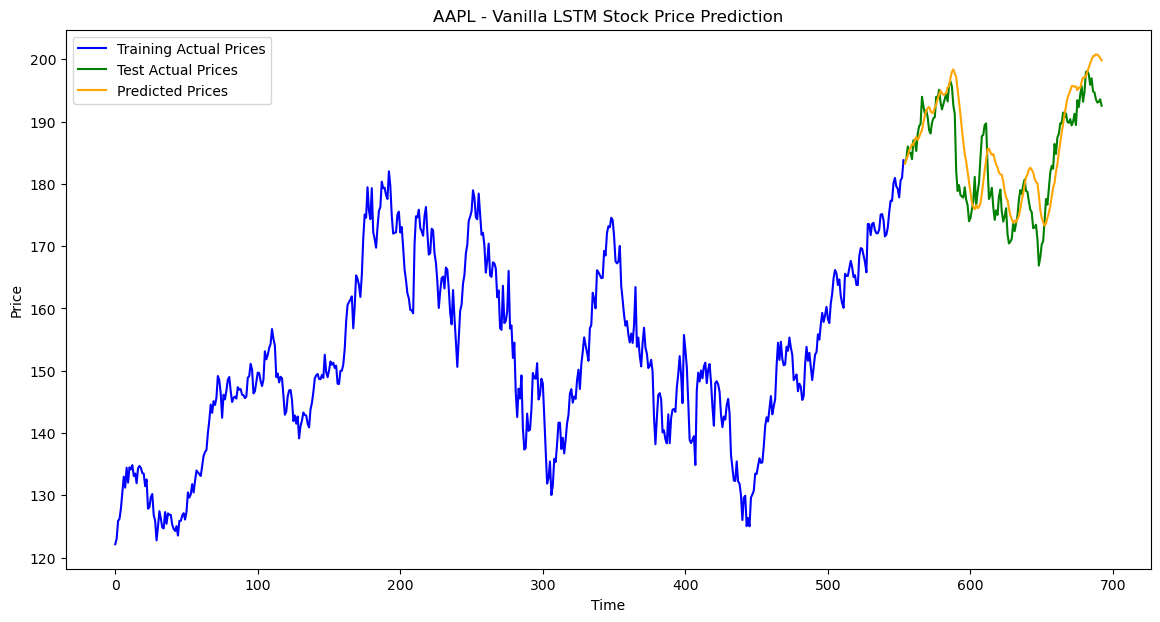

Training Stacked LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


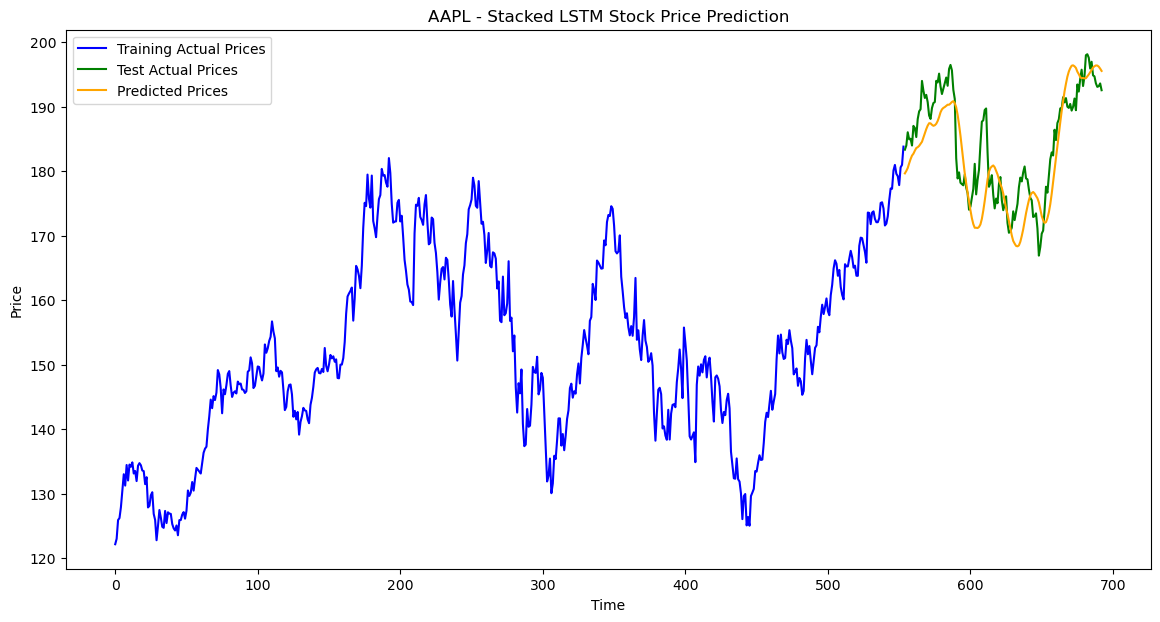

Training Bidirectional LSTM for AAPL...
1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022334669940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


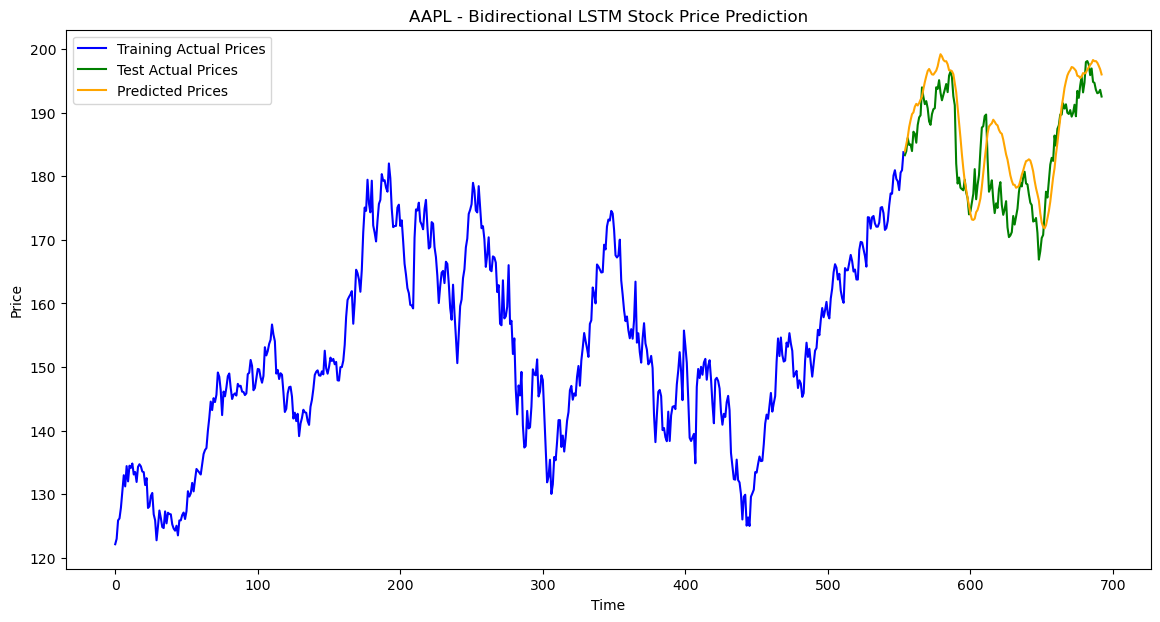

Training CNN-LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


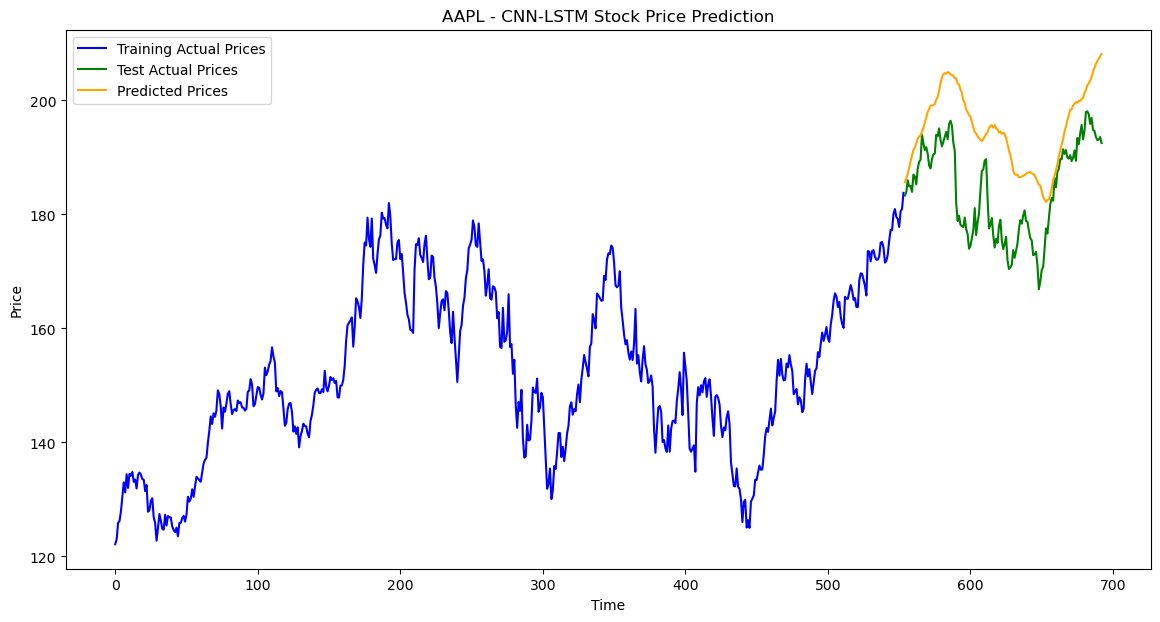

Training Peephole LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


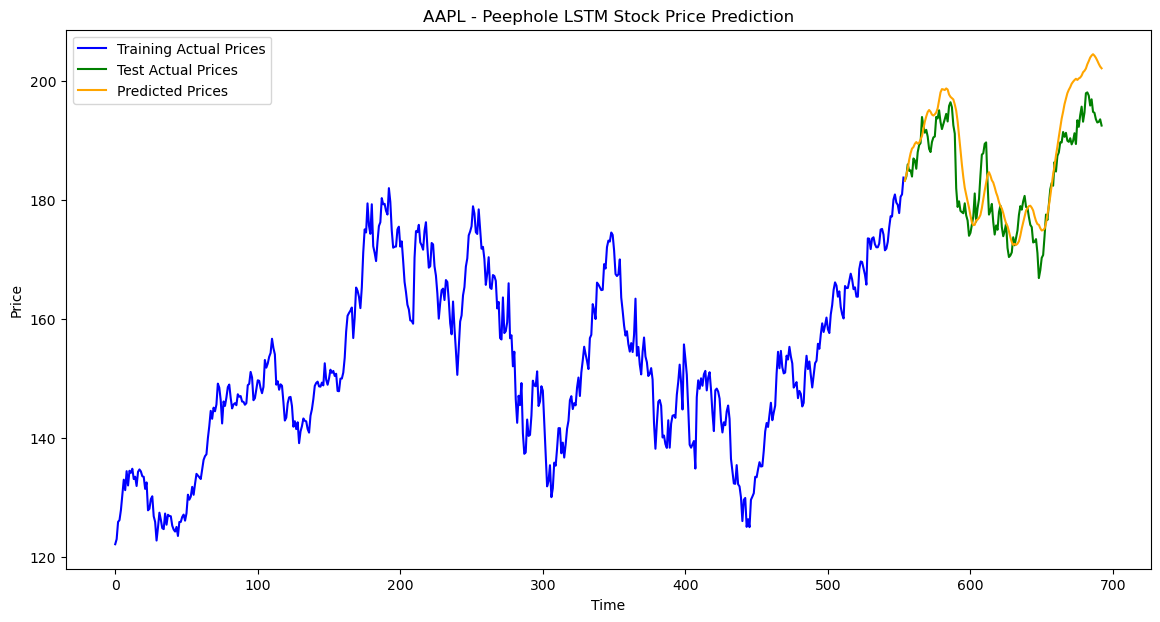

Training Vanilla LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


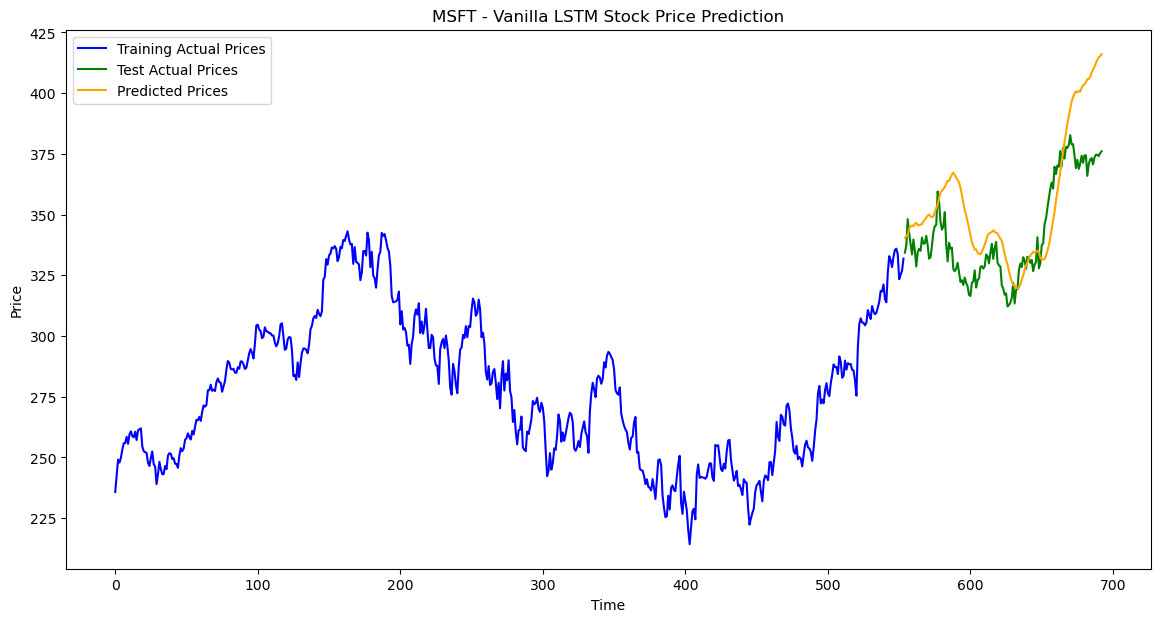

Training Stacked LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


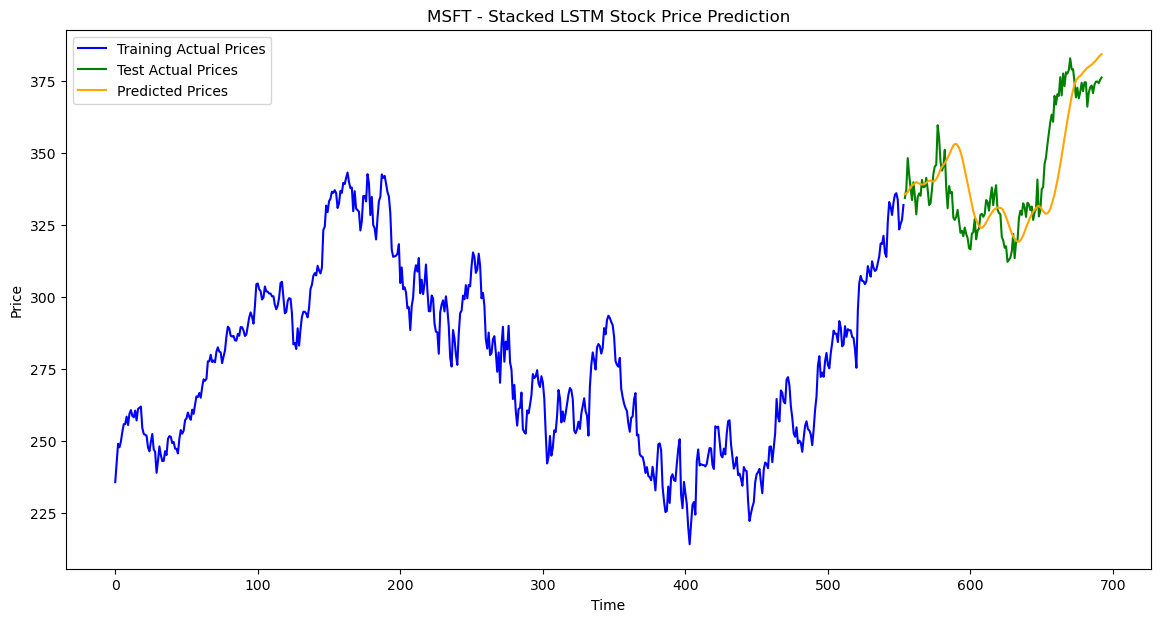

Training Bidirectional LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


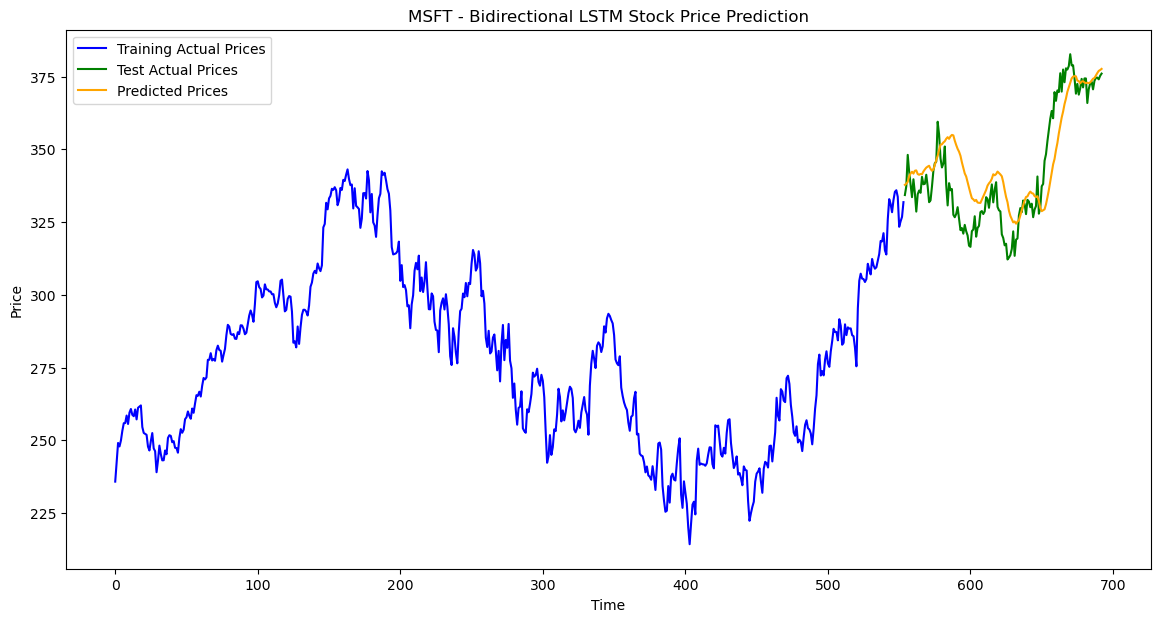

Training CNN-LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


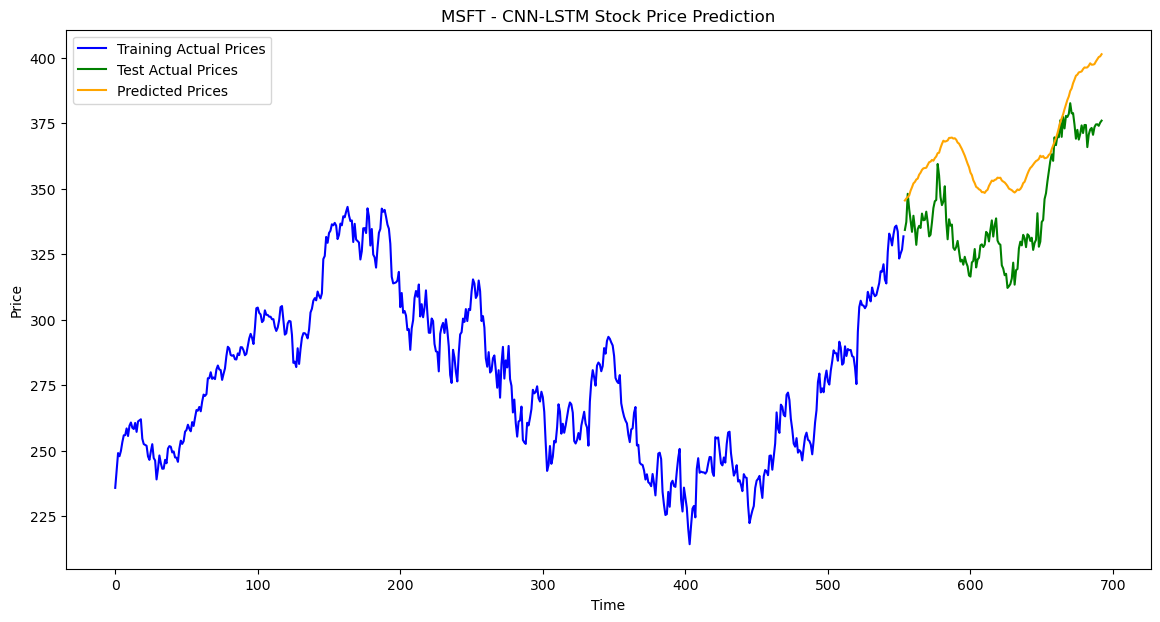

Training Peephole LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


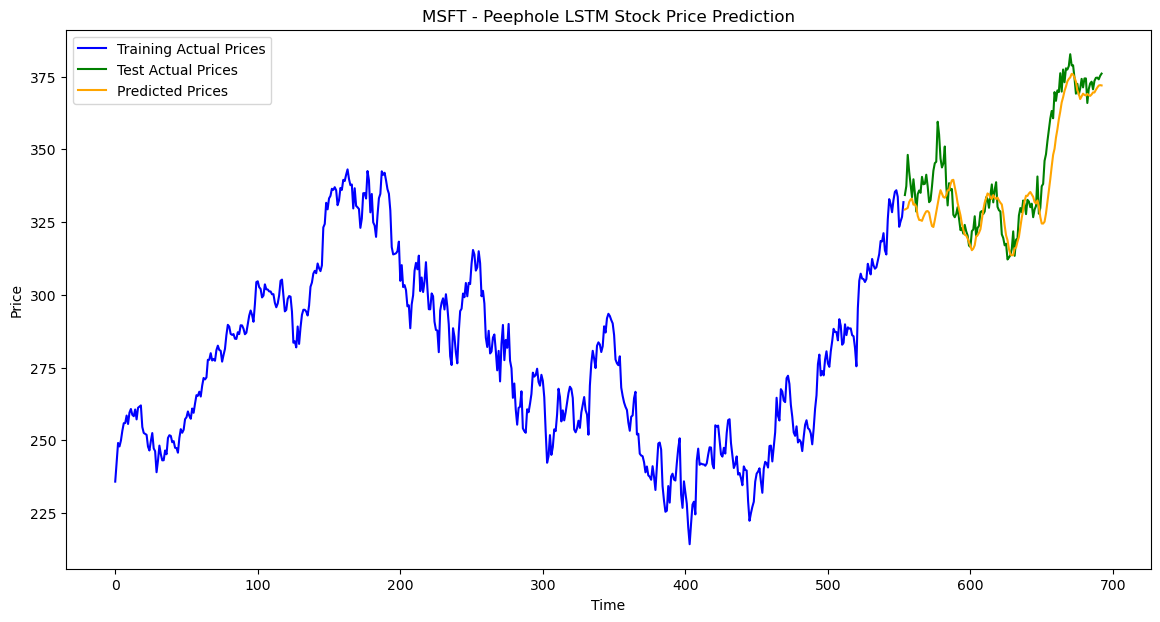

Training Vanilla LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


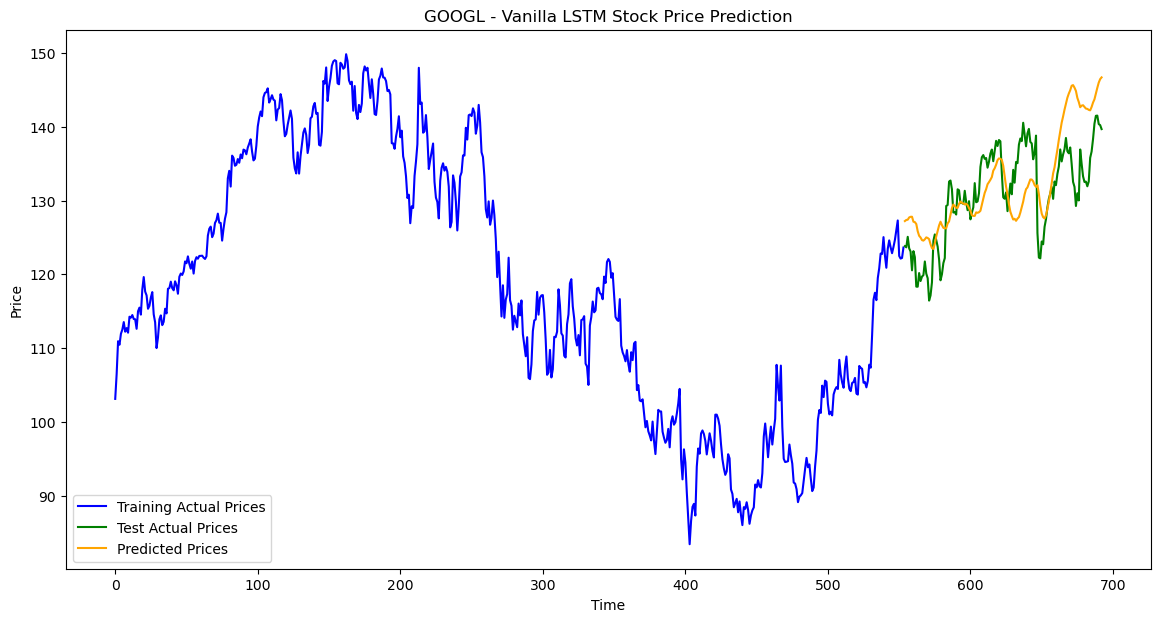

Training Stacked LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


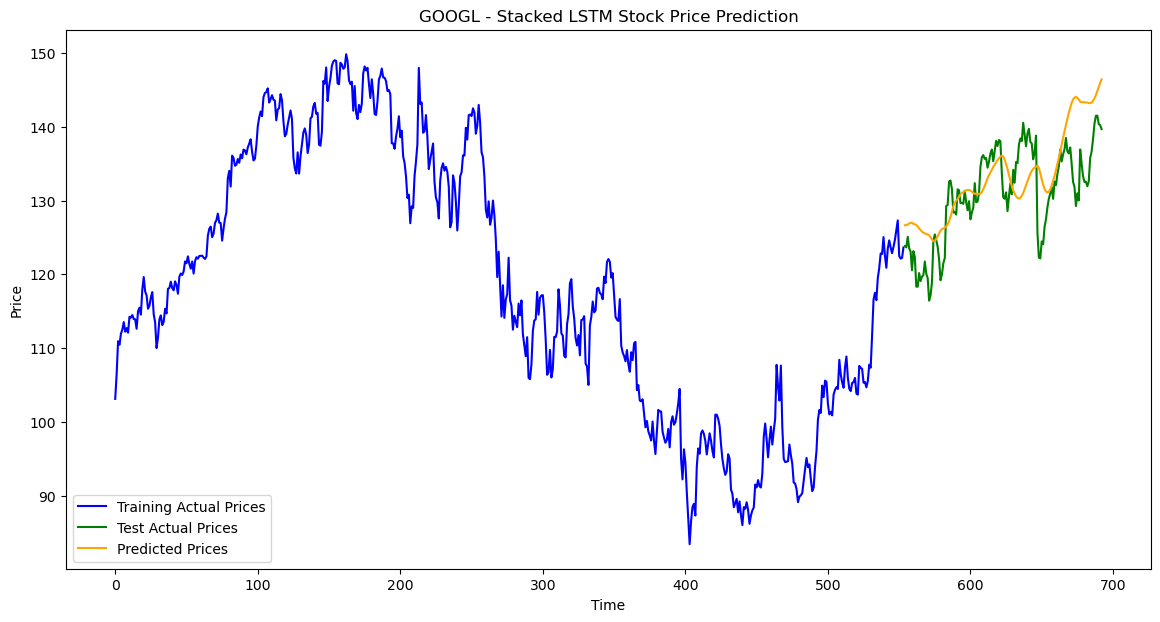

Training Bidirectional LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


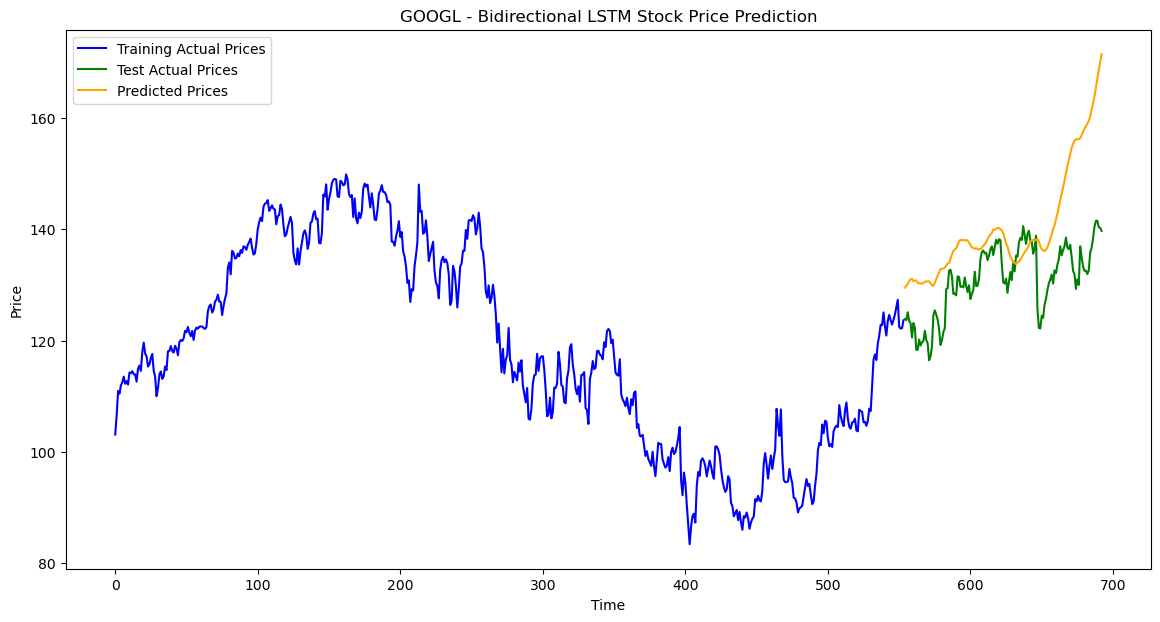

Training CNN-LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


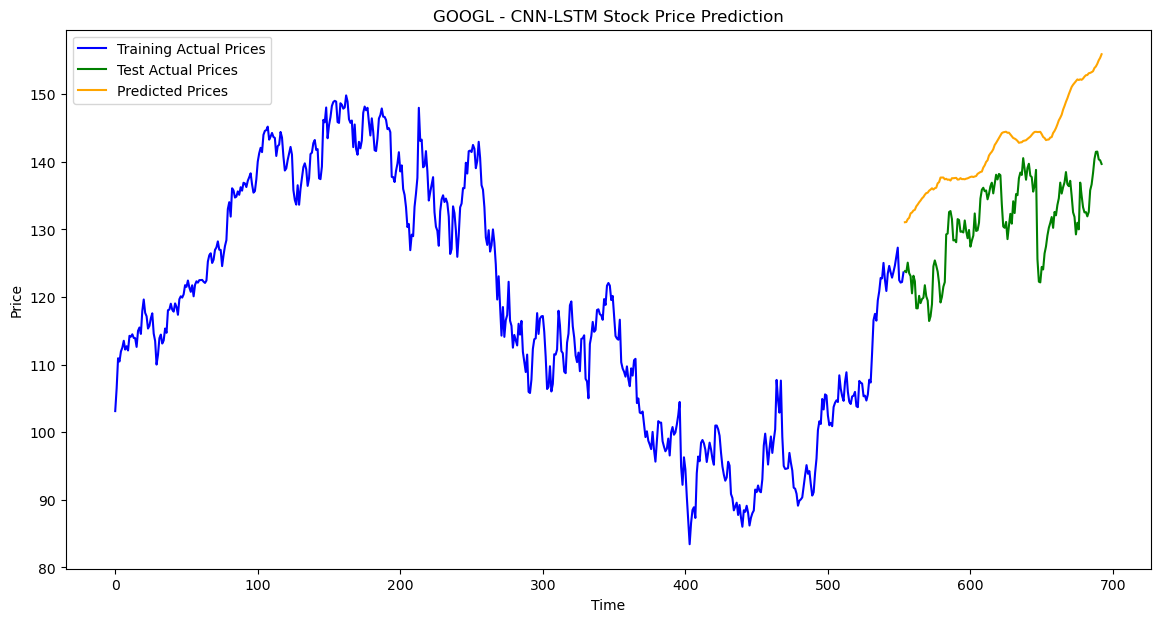

Training Peephole LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


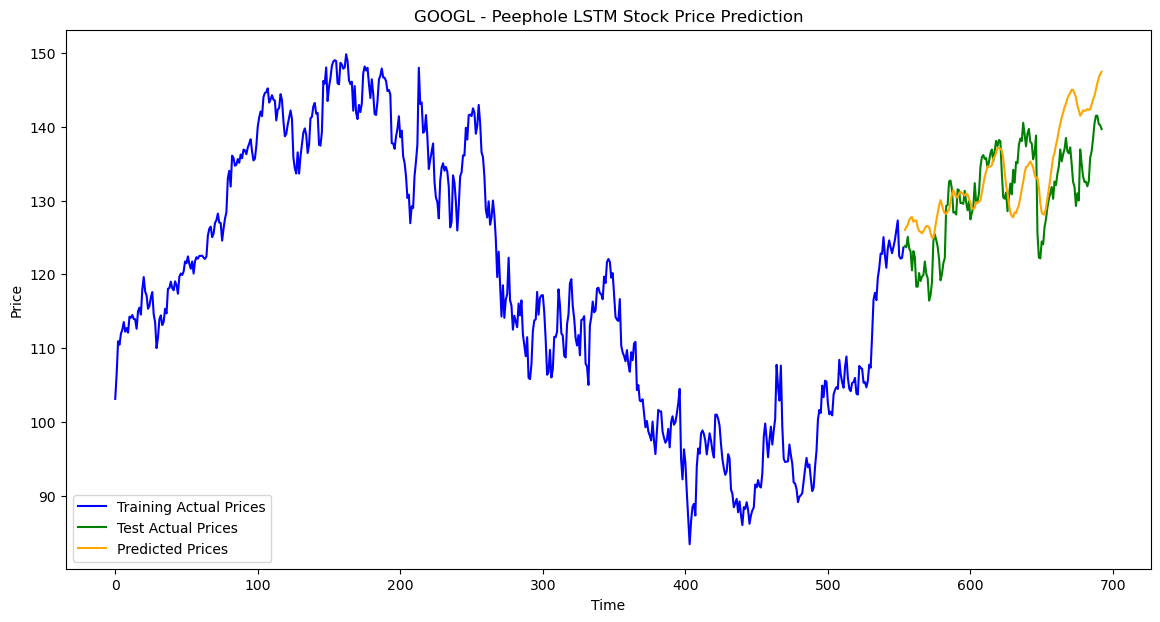

Training Vanilla LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


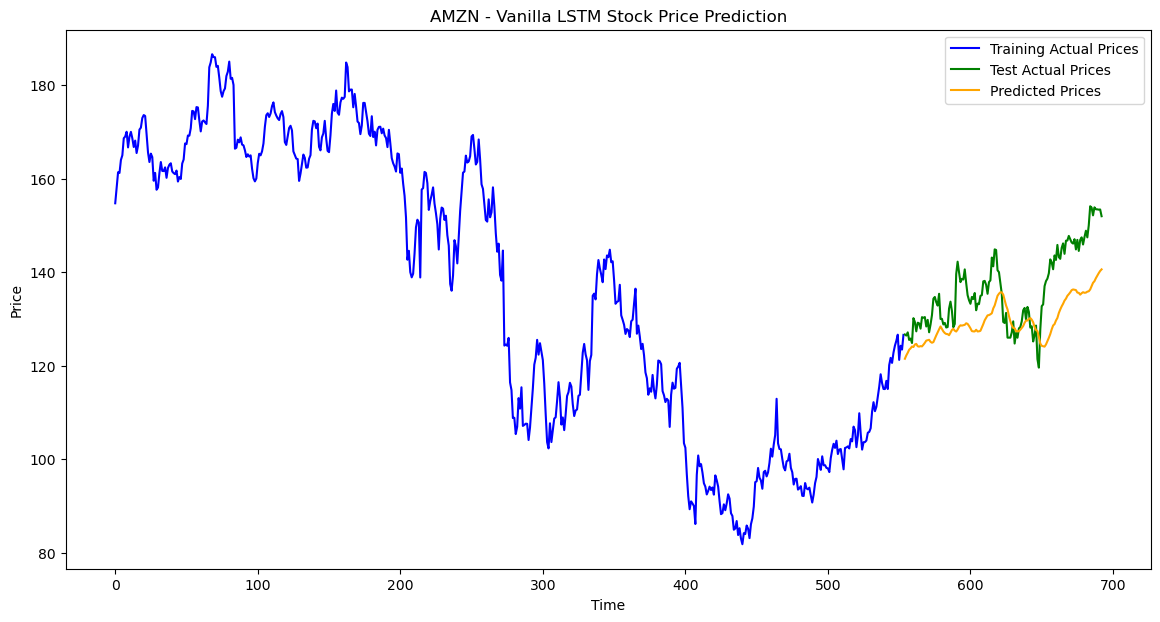

Training Stacked LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step


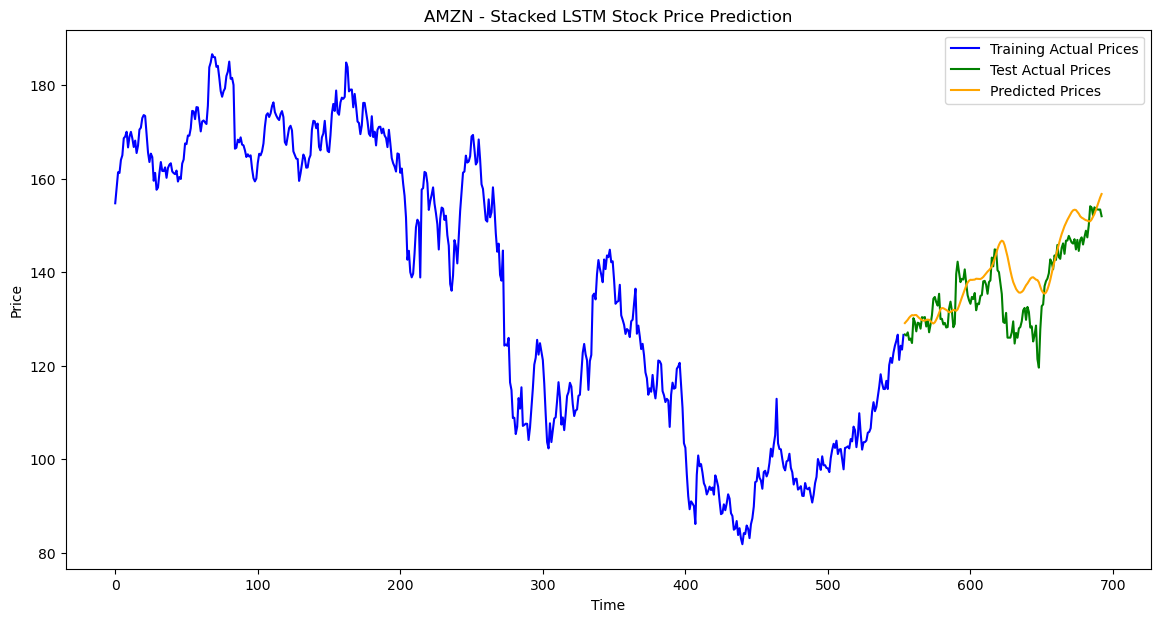

Training Bidirectional LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


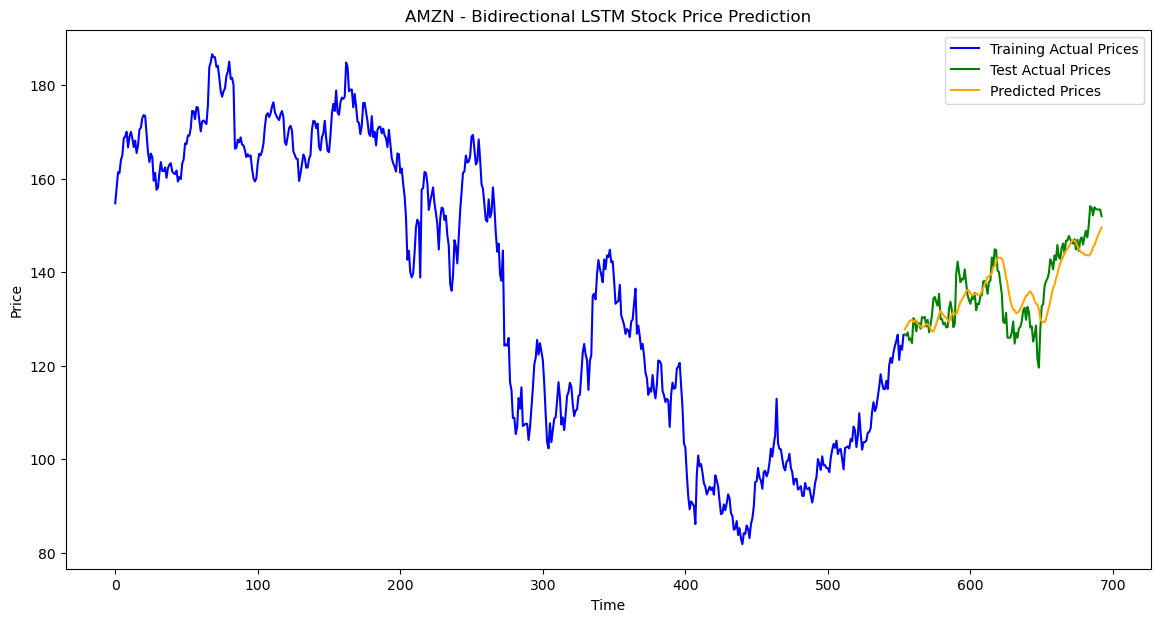

Training CNN-LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


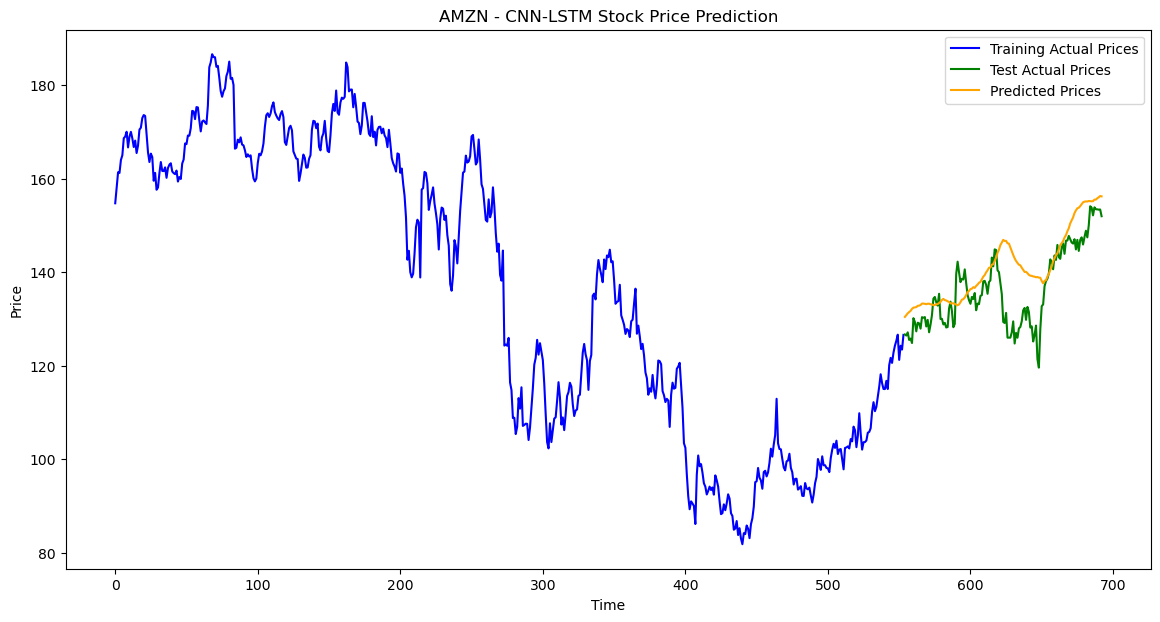

Training Peephole LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


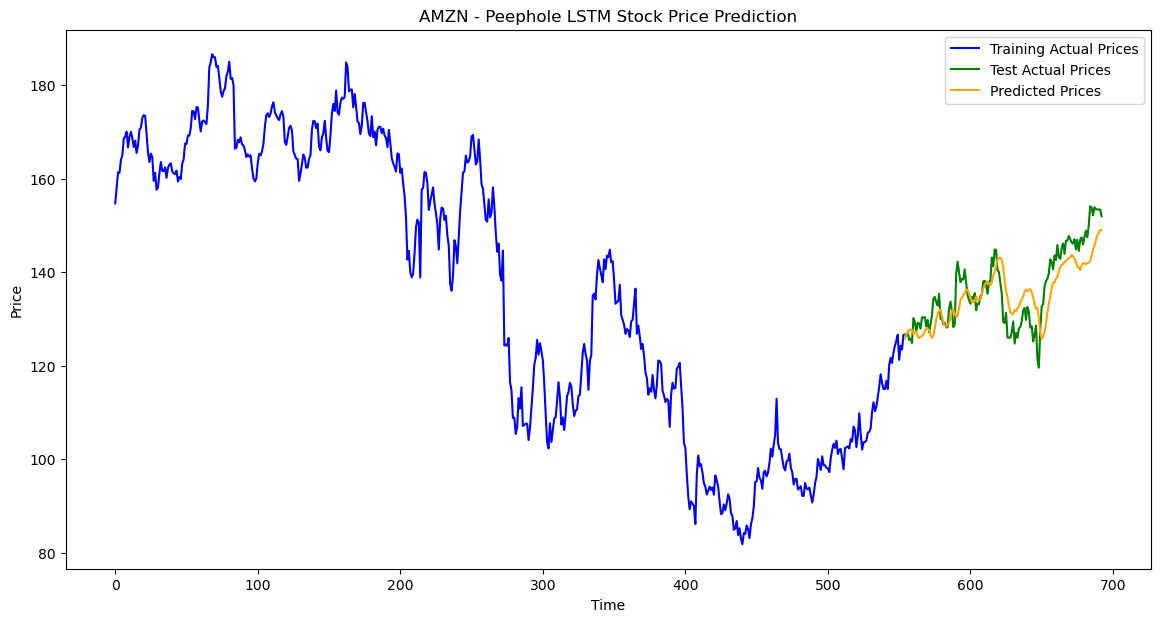

Training Vanilla LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


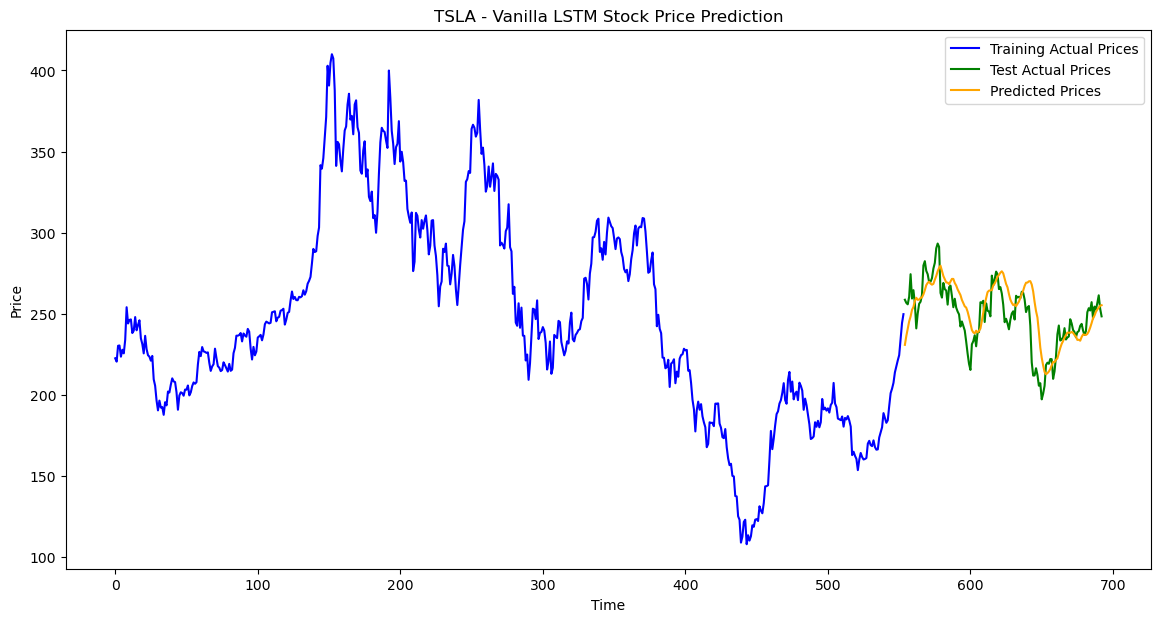

Training Stacked LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


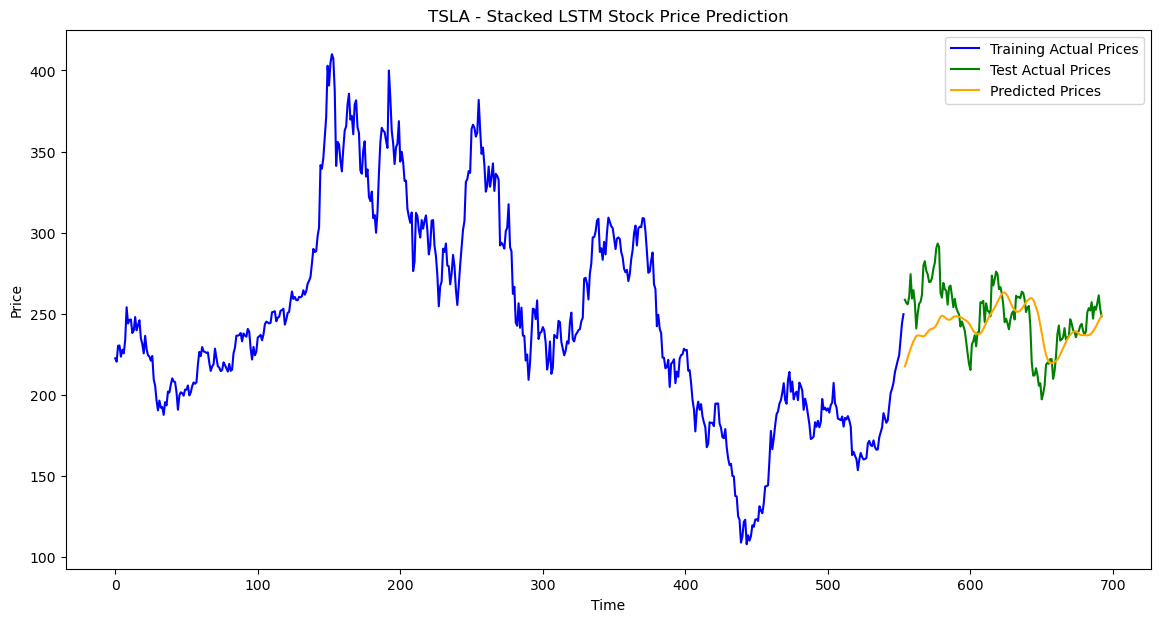

Training Bidirectional LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


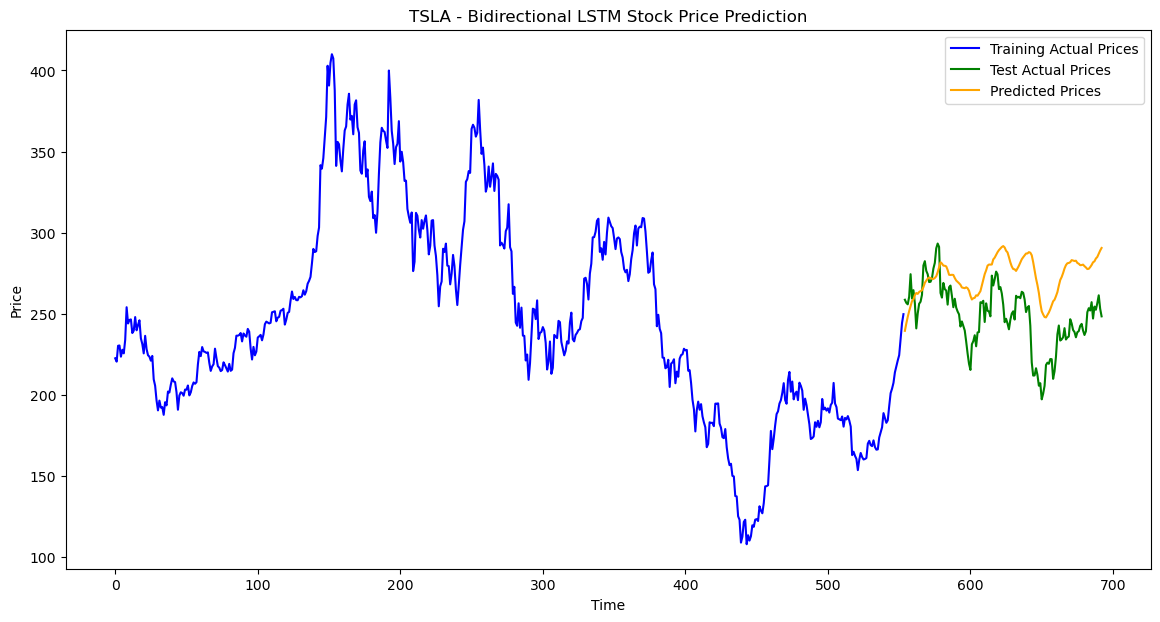

Training CNN-LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


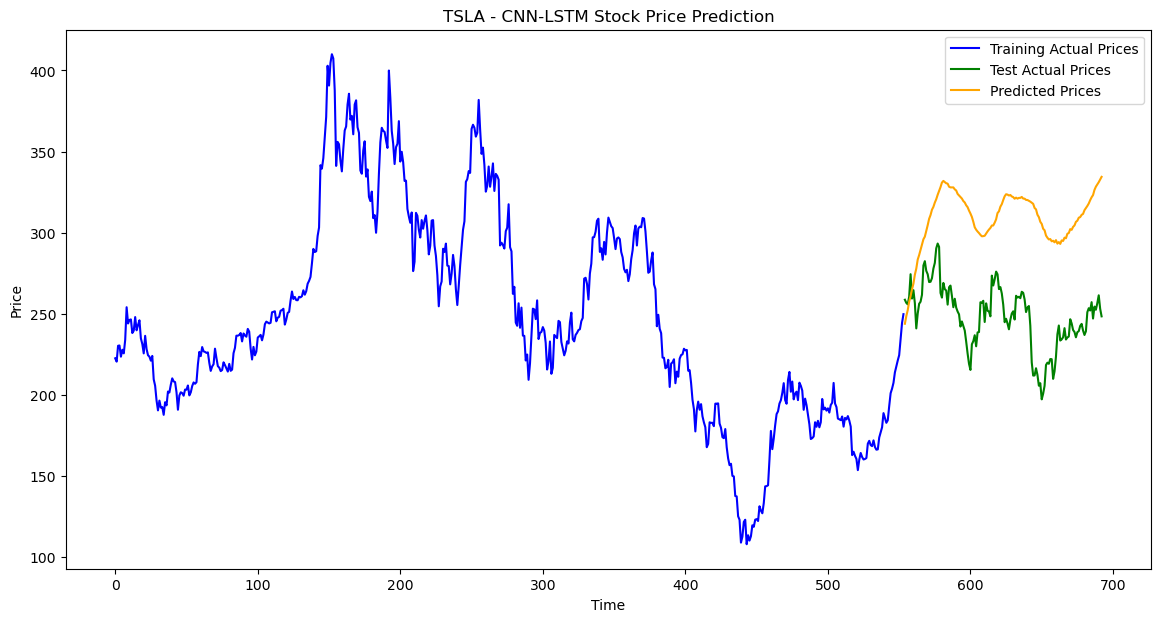

Training Peephole LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


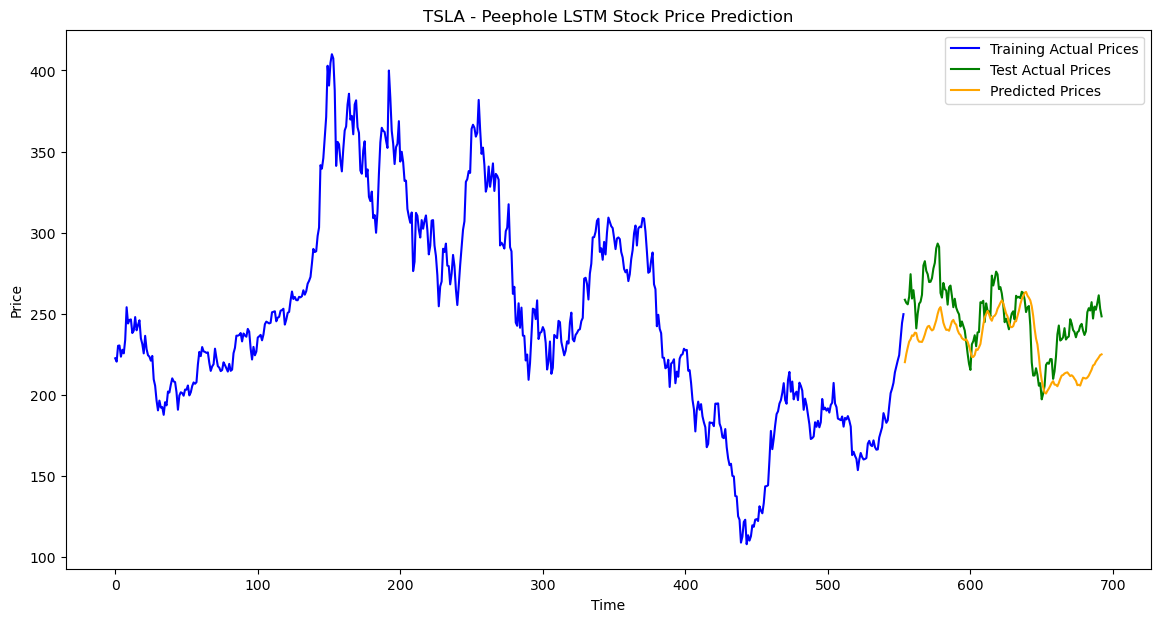

In [33]:
# Main Script
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
data = download_data(tickers, "2021-01-01", "2023-12-31")
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

scaled_data, scaler = preprocess_data(data)
time_steps = 60

results = {}

for ticker_idx, stock_name in enumerate(tickers):
    X, y = create_sequences(scaled_data, time_steps, ticker_idx)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(tickers)))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(tickers)))

    models = {
        "Vanilla LSTM": build_vanilla_lstm,
        "Stacked LSTM": build_stacked_lstm,
        "Bidirectional LSTM": build_bidirectional_lstm,
        "CNN-LSTM": build_cnn_lstm,
        "Peephole LSTM": build_peephole_lstm
    }

    stock_results = {}
    for model_name, model_fn in models.items():
        print(f"Training {model_name} for {stock_name}...")
        if model_name == "Peephole LSTM":
            trial = optuna.trial.FixedTrial({"n_units": 50, "learning_rate": 0.001})
            model = model_fn(trial, (X_train.shape[1], X_train.shape[2]))
        else:
            model = model_fn((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred, exec_time, rmse, mse, mae = evaluate_model(model, X_test, y_test)
        stock_results[model_name] = {"Execution Time": exec_time, "RMSE": rmse, "MSE": mse, "MAE": mae}
        plot_predictions(y_train, y_test, y_pred, scaler, stock_name, model_name, ticker_idx)


    results[stock_name] = pd.DataFrame(stock_results).T

## 1.7 Evaluate performance of models
Model performance is evaluated on with RMSE, MAE and MSE metrics.

In [35]:
# Display results
for stock_name, result_df in results.items():
    print(f"\nPerformance for {stock_name}:")
    print(result_df)


Performance for AAPL:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              0.590779  0.063434  0.004024  0.049443
Stacked LSTM              1.103052  0.063693  0.004057  0.051770
Bidirectional LSTM        1.298273  0.070605  0.004985  0.058187
CNN-LSTM                  0.761602  0.151663  0.023002  0.130710
Peephole LSTM             1.053521  0.067095  0.004502  0.054927

Performance for MSFT:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              0.574581  0.115865  0.013425  0.093086
Stacked LSTM              1.139133  0.077582  0.006019  0.059091
Bidirectional LSTM        1.415594  0.068169  0.004647  0.053172
CNN-LSTM                  0.632226  0.146803  0.021551  0.132320
Peephole LSTM             0.594281  0.051888  0.002692  0.039067

Performance for GOOGL:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              0.699165  0.086046  0.007404  0.070958
Stacked LSTM        

# 2. LSTM with Hyperparameter optimisation

We now systematically optimizes the hyperparameters (e.g., number of LSTM units and learning rate) for each LSTM variant using Optuna. The best parameters are then used to train the final models, ensuring that performance is improved.

## 2.1 Download data, preprocess and create dataset

**2.1.1 Functions for Data Processing and Analysis**

We includes three functions to handle stock data processing. The *download_data* function retrieves historical stock prices for the given tickers and time period, extracts the "Close" prices, renames the columns, and combines them into a single dataset. Missing data is dropped, and an error is raised if no valid data is retrieved. 
The *preprocess_data* function scales the data using MinMaxScaler to normalize values between 0 and 1, returning the scaled data and the scaler for inverse transformations. 
The *create_sequences* function generates input-output pairs for time series prediction, creating sequences of specified length (time_steps) and corresponding target values for a chosen stock (ticker_idx). These functions are essential for preparing stock price data for machine learning or deep learning models.

In [40]:
def download_data(tickers, start, end):
    data = []
    for ticker_symbol in tickers:
        df = yf.download(ticker_symbol, start=start, end=end)[["Close"]]
        df = df.rename(columns={"Close": ticker_symbol})
        data.append(df)
    if not data:
        raise ValueError("No valid data retrieved for the provided tickers.")
    combined_data = pd.concat(data, axis=1).dropna()
    return combined_data

def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_sequences(data, time_steps, ticker_idx):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, ticker_idx])
    return np.array(X), np.array(y)

## 2.2 Build LSTM models
This section contains functions to construct various types of LSTM-based neural network models. Each function uses the `trial` object from the `optuna` library for hyperparameter optimization, allowing for dynamic tuning of the number of LSTM units (`n_units`) and the learning rate (`learning_rate`). 
The Vanilla LSTM model consists of a single LSTM layer with a user-defined number of units and a `relu` activation function. It outputs a single prediction through a dense layer. 

The Stacked LSTM model adds a second LSTM layer, creating a stacked architecture. 

The first LSTM layer outputs sequences, which are passed to the second LSTM layer. 

The Bidirectional LSTM model wraps the LSTM layer in a bidirectional layer to process input data in both forward and backward directions, enhancing learning by capturing temporal dependencies from both directions. 

The CNN-LSTM model combines convolutional layers with max pooling and an LSTM layer. It extracts spatial features through CNN layers and feeds them into the LSTM for temporal modeling. All models use the Adam optimizer with a dynamically tuned learning rate and are compiled with mean squared error as the loss function. These functions provide the flexibility to experiment with different architectures for time series prediction tasks.

In [42]:
def build_vanilla_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    model = Sequential([
        LSTM(n_units, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

def build_stacked_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    model = Sequential([
        LSTM(n_units, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(n_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

def build_bidirectional_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    model = Sequential([
        Bidirectional(LSTM(n_units, activation='relu', input_shape=input_shape)),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

def build_cnn_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(n_units, activation='relu'),
        Reshape((1, n_units)),
        LSTM(n_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

**2.2.1 Creating a Peephole LSTM cell**

This is necessary as there is no native way of doing this in Keras.

In [44]:
class PeepholeLSTMCell(Layer):
    def __init__(self, units, **kwargs):
        super(PeepholeLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = [units, units]  # Hidden state and cell state
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Define weights for inputs, hidden states, and peephole connections
        self.W_x = self.add_weight(shape=(input_dim, self.units * 4), initializer="glorot_uniform", name="W_x")
        self.W_h = self.add_weight(shape=(self.units, self.units * 4), initializer="glorot_uniform", name="W_h")
        self.W_c_i = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_i")  # Peephole for input gate
        self.W_c_f = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_f")  # Peephole for forget gate
        self.W_c_o = self.add_weight(shape=(self.units,), initializer="glorot_uniform", name="W_c_o")  # Peephole for output gate
        self.b = self.add_weight(shape=(self.units * 4,), initializer="zeros", name="b")

    def call(self, inputs, states):
        h_tm1, c_tm1 = states  # Previous hidden state and cell state
        z = tf.matmul(inputs, self.W_x) + tf.matmul(h_tm1, self.W_h) + self.b
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=-1)

        # Peephole connections: Adding cell state to gates
        i = tf.sigmoid(z0 + c_tm1 * self.W_c_i)  # Input gate
        f = tf.sigmoid(z1 + c_tm1 * self.W_c_f)  # Forget gate
        o = tf.sigmoid(z2 + c_tm1 * self.W_c_o)  # Output gate
        c = f * c_tm1 + i * tf.tanh(z3)          # Cell state
        h = o * tf.tanh(c)                       # Hidden state
        return h, [h, c]


Creating a build_peephole_lstm function

In [46]:
def build_peephole_lstm(trial, input_shape):
    n_units = trial.suggest_int("n_units", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    
    model = Sequential([
        RNN(PeepholeLSTMCell(n_units), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


## 2.3 The evaluate model function 



The `evaluate_model` function assesses the performance of a trained model on test data. It measures the time taken for the model to generate predictions, calculates error metrics, and returns the results. The function takes the trained model, test input data (`X_test`), and test target data (`y_test`) as inputs. Predictions are generated using the model's `predict` method, and the execution time is calculated as the difference between the start and end times. The predictions are flattened to match the target data's shape. 

The function computes three evaluation metrics: Root Mean Squared Error (RMSE), Mean Squared Error (MSE), and Mean Absolute Error (MAE). These metrics provide insight into the model's accuracy and error distribution. The function returns the predictions, execution time, RMSE, MSE, and MAE for further ana.

---

In [48]:
def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    predictions = model.predict(X_test)
    exec_time = time.time() - start_time
    predictions = predictions.flatten()
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return predictions, exec_time, rmse, mse, mae

## 2.4 Plotting predictions


The `plot_predictions` function visualizes the actual and predicted stock prices for a given stock and model. It takes as input the training target values (`y_train`), test target values (`y_test`), predicted values (`y_pred`), the scaler used for data preprocessing, the stock name, model name, and the index of the ticker being analyzedlot.

The actual training prices are displayed in blue, the actual test prices in green, and the predicted prices in orange. The plot includes appropriate labels, a title that specifies the stock name and model used, and a legend for clarity. This visualization provides a clear comparison of the model's predictions against the actual stock prices ovme.

---

In [50]:
def plot_predictions(y_train, y_test, y_pred, scaler, stock_name, model_name, ticker_idx):
    plt.figure(figsize=(14, 7))
    
    train_range = range(len(y_train))
    test_range = range(len(y_train), len(y_train) + len(y_test))

    dummy_actual = np.zeros((len(y_train) + len(y_test), scaler.n_features_in_))
    dummy_predicted = np.zeros((len(y_pred), scaler.n_features_in_))

    dummy_actual[:, ticker_idx] = np.concatenate((y_train, y_test))
    dummy_predicted[:, ticker_idx] = y_pred

    actual_prices = scaler.inverse_transform(dummy_actual)[:, ticker_idx]
    predicted_prices = scaler.inverse_transform(dummy_predicted)[:, ticker_idx]

    plt.plot(train_range, actual_prices[:len(y_train)], label='Training Actual Prices', color='blue')
    plt.plot(test_range, actual_prices[len(y_train):], label='Test Actual Prices', color='green')
    plt.plot(test_range, predicted_prices, label='Predicted Prices', color='orange')

    plt.title(f'{stock_name} - {model_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## 2.5 Model optimisation



The `optimize_model` function uses Optuna to optimize the hyperparameters of a given model. It takes a model-building function (`build_fn`), training and testing data, and the input shape as arguments. The `objective` function within defines the optimization target, which trains the model and evaluates it using the RMSE metric. Optuna minimizes the RMSE over multiple trials to find the best hyperparameters. The function returns the optimal hyperparameters identified by the study.

The main script begins by defining the list of stock tickers, downloading their historical price data, and filling any missing values using forward and backward fill methods. The data is then scaled using MinMaxScaler, and sequences are created for time series modeling with a time step size of 60.

The `results` dictionary is initialized to store model evaluation details for each stock and model, while `performance_summary` is prepared to summarize overall performance across models and tickers. This setup lays the foundation for model training, hyperparameter optimization, and evaon.

---

In [52]:
def optimize_model(build_fn, X_train, y_train, X_test, y_test, input_shape):
    def objective(trial):
        model = build_fn(trial, input_shape)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        _, _, rmse, _, _ = evaluate_model(model, X_test, y_test)
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    return study.best_params

# Main Script
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
data = download_data(tickers, "2021-01-01", "2023-12-31")
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

scaled_data, scaler = preprocess_data(data)
time_steps = 60

results = {}
performance_summary = []

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Model performance

[I 2024-12-18 23:10:24,673] A new study created in memory with name: no-name-7e9c75e2-8f6d-4d56-83ec-37f36349d48c


Optimizing Vanilla LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:10:35,991] Trial 0 finished with value: 0.24420695280604032 and parameters: {'n_units': 67, 'learning_rate': 0.00013219893467715104}. Best is trial 0 with value: 0.24420695280604032.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:10:50,118] Trial 1 finished with value: 0.07408567185813345 and parameters: {'n_units': 79, 'learning_rate': 0.0009588473765268663}. Best is trial 1 with value: 0.07408567185813345.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step


[I 2024-12-18 23:11:01,704] Trial 2 finished with value: 0.3431836322283712 and parameters: {'n_units': 11, 'learning_rate': 6.0435810317136815e-05}. Best is trial 1 with value: 0.07408567185813345.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


[I 2024-12-18 23:11:12,975] Trial 3 finished with value: 0.05055156769964577 and parameters: {'n_units': 20, 'learning_rate': 0.0006037660625015544}. Best is trial 3 with value: 0.05055156769964577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2024-12-18 23:11:28,889] Trial 4 finished with value: 0.08127931459716878 and parameters: {'n_units': 52, 'learning_rate': 0.0007468766818973625}. Best is trial 3 with value: 0.05055156769964577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


[I 2024-12-18 23:11:42,000] Trial 5 finished with value: 0.538745178581572 and parameters: {'n_units': 41, 'learning_rate': 3.565989164352373e-05}. Best is trial 3 with value: 0.05055156769964577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:11:57,874] Trial 6 finished with value: 0.7092894748440977 and parameters: {'n_units': 100, 'learning_rate': 1.928611254002432e-05}. Best is trial 3 with value: 0.05055156769964577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2024-12-18 23:12:10,283] Trial 7 finished with value: 0.7962617722326077 and parameters: {'n_units': 31, 'learning_rate': 1.2492361837726978e-05}. Best is trial 3 with value: 0.05055156769964577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


[I 2024-12-18 23:12:24,338] Trial 8 finished with value: 0.04587979718870529 and parameters: {'n_units': 65, 'learning_rate': 0.0026331496741465034}. Best is trial 8 with value: 0.04587979718870529.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2024-12-18 23:12:37,134] Trial 9 finished with value: 0.08897082787663282 and parameters: {'n_units': 67, 'learning_rate': 0.00016862548064723652}. Best is trial 8 with value: 0.04587979718870529.


Best params for Vanilla LSTM: {'n_units': 65, 'learning_rate': 0.0026331496741465034}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


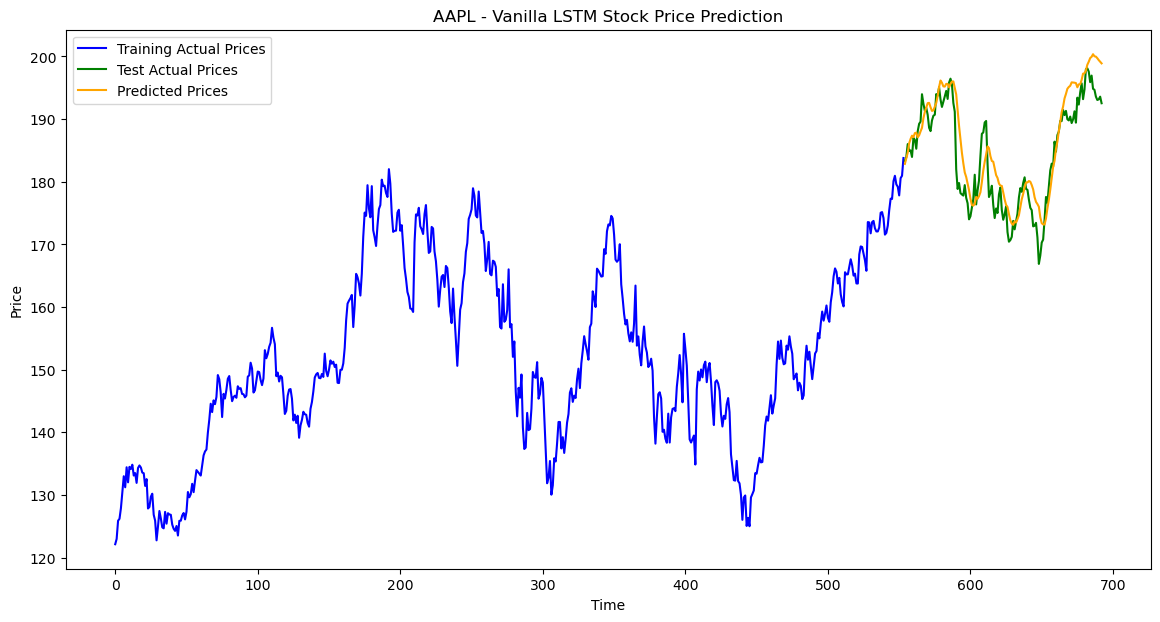

[I 2024-12-18 23:12:46,475] A new study created in memory with name: no-name-b9144c6d-d2eb-4475-98b3-522476cd28ea


Optimizing Stacked LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:12:59,393] Trial 0 finished with value: 0.09766715035494733 and parameters: {'n_units': 57, 'learning_rate': 0.00035067935644062485}. Best is trial 0 with value: 0.09766715035494733.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:13:10,254] Trial 1 finished with value: 0.09036132726164983 and parameters: {'n_units': 67, 'learning_rate': 0.0010310850771627724}. Best is trial 1 with value: 0.09036132726164983.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2024-12-18 23:13:22,719] Trial 2 finished with value: 0.3692732976326284 and parameters: {'n_units': 71, 'learning_rate': 4.337005025457963e-05}. Best is trial 1 with value: 0.09036132726164983.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:13:37,976] Trial 3 finished with value: 0.11928013684227613 and parameters: {'n_units': 74, 'learning_rate': 0.00026633667695488586}. Best is trial 1 with value: 0.09036132726164983.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2024-12-18 23:13:50,980] Trial 4 finished with value: 0.17846994222224466 and parameters: {'n_units': 79, 'learning_rate': 0.0003656842022394695}. Best is trial 1 with value: 0.09036132726164983.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:13:59,865] Trial 5 finished with value: 0.3436736292197279 and parameters: {'n_units': 22, 'learning_rate': 0.00016746619249466288}. Best is trial 1 with value: 0.09036132726164983.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-18 23:14:09,884] Trial 6 finished with value: 0.07500197221025572 and parameters: {'n_units': 51, 'learning_rate': 0.00028087053225446973}. Best is trial 6 with value: 0.07500197221025572.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:14:18,645] Trial 7 finished with value: 0.6953317907962638 and parameters: {'n_units': 27, 'learning_rate': 3.073847501139559e-05}. Best is trial 6 with value: 0.07500197221025572.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2024-12-18 23:14:29,557] Trial 8 finished with value: 0.663937028065918 and parameters: {'n_units': 80, 'learning_rate': 2.2132406485520754e-05}. Best is trial 6 with value: 0.07500197221025572.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


[I 2024-12-18 23:14:42,560] Trial 9 finished with value: 0.48558338362549974 and parameters: {'n_units': 75, 'learning_rate': 3.7526288419241784e-05}. Best is trial 6 with value: 0.07500197221025572.


Best params for Stacked LSTM: {'n_units': 51, 'learning_rate': 0.00028087053225446973}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


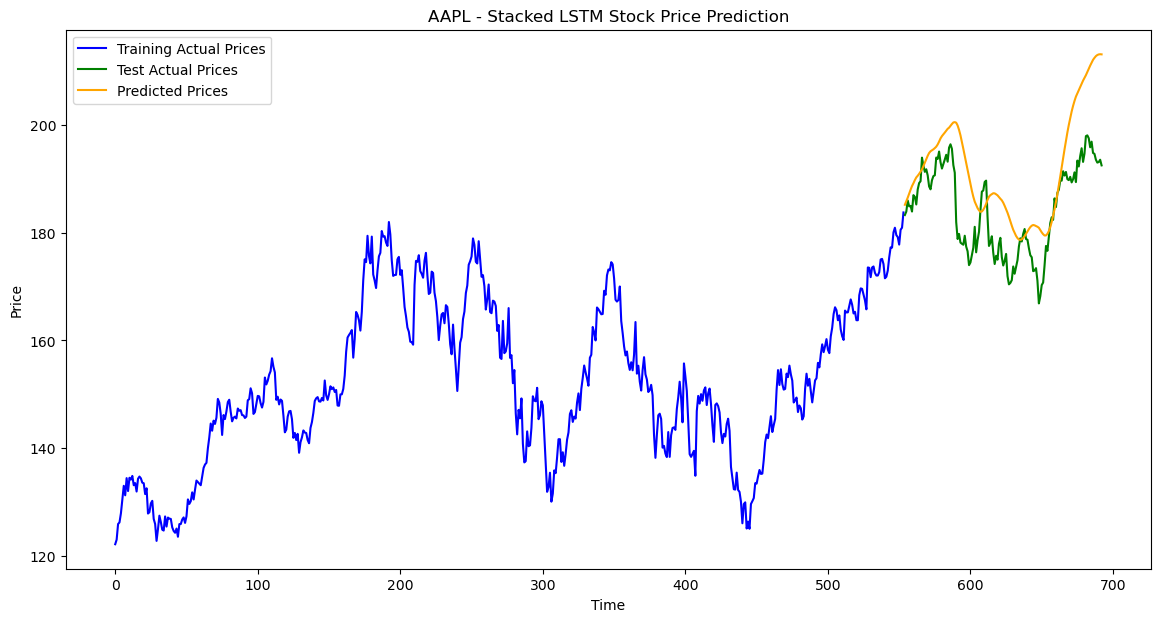

[I 2024-12-18 23:14:59,364] A new study created in memory with name: no-name-39de57b3-061e-46e1-b185-a3e0ee0fbf83


Optimizing Bidirectional LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-18 23:15:09,293] Trial 0 finished with value: 0.8778381278993034 and parameters: {'n_units': 54, 'learning_rate': 1.2348484075675357e-05}. Best is trial 0 with value: 0.8778381278993034.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:15:19,214] Trial 1 finished with value: 0.058786488303559536 and parameters: {'n_units': 50, 'learning_rate': 0.00047143107668950123}. Best is trial 1 with value: 0.058786488303559536.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2024-12-18 23:15:29,206] Trial 2 finished with value: 0.19687646820162694 and parameters: {'n_units': 47, 'learning_rate': 0.0001056612547065366}. Best is trial 1 with value: 0.058786488303559536.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:15:40,285] Trial 3 finished with value: 0.08906439460116526 and parameters: {'n_units': 60, 'learning_rate': 0.000381268209487572}. Best is trial 1 with value: 0.058786488303559536.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-18 23:15:51,724] Trial 4 finished with value: 0.05061510560643543 and parameters: {'n_units': 26, 'learning_rate': 0.0003904906964276971}. Best is trial 4 with value: 0.05061510560643543.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:16:02,078] Trial 5 finished with value: 0.03648369873565956 and parameters: {'n_units': 67, 'learning_rate': 0.002761842632789079}. Best is trial 5 with value: 0.03648369873565956.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2024-12-18 23:16:10,324] Trial 6 finished with value: 0.04193270800608876 and parameters: {'n_units': 18, 'learning_rate': 0.0045088395764675}. Best is trial 5 with value: 0.03648369873565956.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2024-12-18 23:16:21,580] Trial 7 finished with value: 0.7926164933924572 and parameters: {'n_units': 50, 'learning_rate': 1.1447965918097196e-05}. Best is trial 5 with value: 0.03648369873565956.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:16:32,935] Trial 8 finished with value: 0.7137737367898954 and parameters: {'n_units': 84, 'learning_rate': 1.2954121836028682e-05}. Best is trial 5 with value: 0.03648369873565956.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2024-12-18 23:16:43,012] Trial 9 finished with value: 0.055922891370607825 and parameters: {'n_units': 93, 'learning_rate': 0.0009319571142105619}. Best is trial 5 with value: 0.03648369873565956.


Best params for Bidirectional LSTM: {'n_units': 67, 'learning_rate': 0.002761842632789079}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


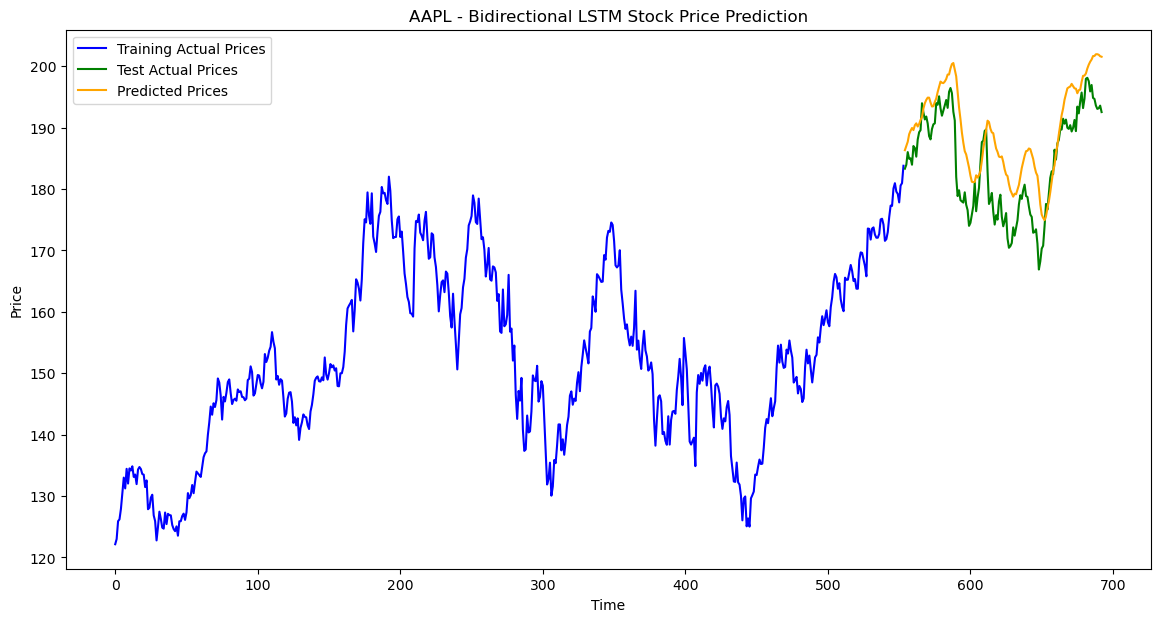

[I 2024-12-18 23:16:56,820] A new study created in memory with name: no-name-6fde14c8-1241-4c97-b611-fb83dab1b4f8


Optimizing CNN-LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:17:08,209] Trial 0 finished with value: 0.8840753598871899 and parameters: {'n_units': 33, 'learning_rate': 2.084732853120218e-05}. Best is trial 0 with value: 0.8840753598871899.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2024-12-18 23:17:19,126] Trial 1 finished with value: 0.1616103557258669 and parameters: {'n_units': 33, 'learning_rate': 0.0002036193337874277}. Best is trial 1 with value: 0.1616103557258669.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2024-12-18 23:17:30,536] Trial 2 finished with value: 0.08847058419597055 and parameters: {'n_units': 65, 'learning_rate': 0.0005535570531339871}. Best is trial 2 with value: 0.08847058419597055.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2024-12-18 23:17:42,866] Trial 3 finished with value: 0.22376397204466084 and parameters: {'n_units': 72, 'learning_rate': 9.530058169427742e-05}. Best is trial 2 with value: 0.08847058419597055.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:17:55,273] Trial 4 finished with value: 0.043643758328030025 and parameters: {'n_units': 60, 'learning_rate': 0.002391879253721092}. Best is trial 4 with value: 0.043643758328030025.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2024-12-18 23:18:07,957] Trial 5 finished with value: 0.18197369570518143 and parameters: {'n_units': 62, 'learning_rate': 0.00012457967045020202}. Best is trial 4 with value: 0.043643758328030025.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2024-12-18 23:18:19,512] Trial 6 finished with value: 0.12093917286126342 and parameters: {'n_units': 66, 'learning_rate': 0.0001998255532613792}. Best is trial 4 with value: 0.043643758328030025.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:18:32,662] Trial 7 finished with value: 0.08931341325134433 and parameters: {'n_units': 89, 'learning_rate': 0.0011558695994576468}. Best is trial 4 with value: 0.043643758328030025.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


[I 2024-12-18 23:18:43,519] Trial 8 finished with value: 0.07078383877762813 and parameters: {'n_units': 68, 'learning_rate': 0.00029747992422749777}. Best is trial 4 with value: 0.043643758328030025.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2024-12-18 23:18:58,246] Trial 9 finished with value: 0.5704370515451785 and parameters: {'n_units': 94, 'learning_rate': 2.232675711788357e-05}. Best is trial 4 with value: 0.043643758328030025.


Best params for CNN-LSTM: {'n_units': 60, 'learning_rate': 0.002391879253721092}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


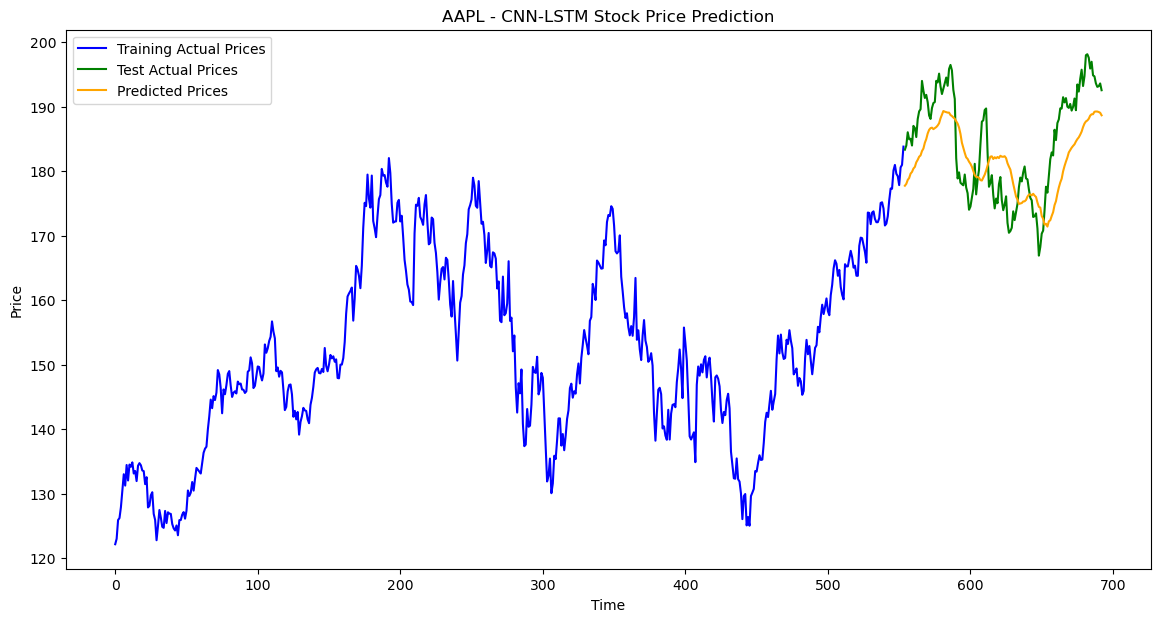

[I 2024-12-18 23:19:04,631] A new study created in memory with name: no-name-bc1eb251-8e12-4157-8516-03f5b6201555


Optimizing Peephole LSTM for AAPL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


[I 2024-12-18 23:19:16,636] Trial 0 finished with value: 0.6282387420231844 and parameters: {'n_units': 83, 'learning_rate': 2.3534412379154508e-05}. Best is trial 0 with value: 0.6282387420231844.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2024-12-18 23:19:26,656] Trial 1 finished with value: 0.09083388434874447 and parameters: {'n_units': 19, 'learning_rate': 0.0006798711130035723}. Best is trial 1 with value: 0.09083388434874447.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[I 2024-12-18 23:19:39,402] Trial 2 finished with value: 0.7732015698057654 and parameters: {'n_units': 57, 'learning_rate': 1.0930911565635494e-05}. Best is trial 1 with value: 0.09083388434874447.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


[I 2024-12-18 23:19:49,196] Trial 3 finished with value: 0.06778467729850142 and parameters: {'n_units': 24, 'learning_rate': 0.0006756667087894657}. Best is trial 3 with value: 0.06778467729850142.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2024-12-18 23:20:00,996] Trial 4 finished with value: 0.17765077916439995 and parameters: {'n_units': 94, 'learning_rate': 6.620473562944696e-05}. Best is trial 3 with value: 0.06778467729850142.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[I 2024-12-18 23:20:11,829] Trial 5 finished with value: 0.07906807082699371 and parameters: {'n_units': 71, 'learning_rate': 0.00046625530201961104}. Best is trial 3 with value: 0.06778467729850142.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:20:22,786] Trial 6 finished with value: 0.05492581536089226 and parameters: {'n_units': 60, 'learning_rate': 0.00025011953896306985}. Best is trial 6 with value: 0.05492581536089226.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2024-12-18 23:20:34,208] Trial 7 finished with value: 0.03800898573703632 and parameters: {'n_units': 92, 'learning_rate': 0.0028581288737828062}. Best is trial 7 with value: 0.03800898573703632.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


[I 2024-12-18 23:20:44,201] Trial 8 finished with value: 0.6136115402431331 and parameters: {'n_units': 56, 'learning_rate': 1.103076342723712e-05}. Best is trial 7 with value: 0.03800898573703632.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-18 23:20:54,447] Trial 9 finished with value: 0.585017628354007 and parameters: {'n_units': 26, 'learning_rate': 7.20935108806627e-05}. Best is trial 7 with value: 0.03800898573703632.


Best params for Peephole LSTM: {'n_units': 92, 'learning_rate': 0.0028581288737828062}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


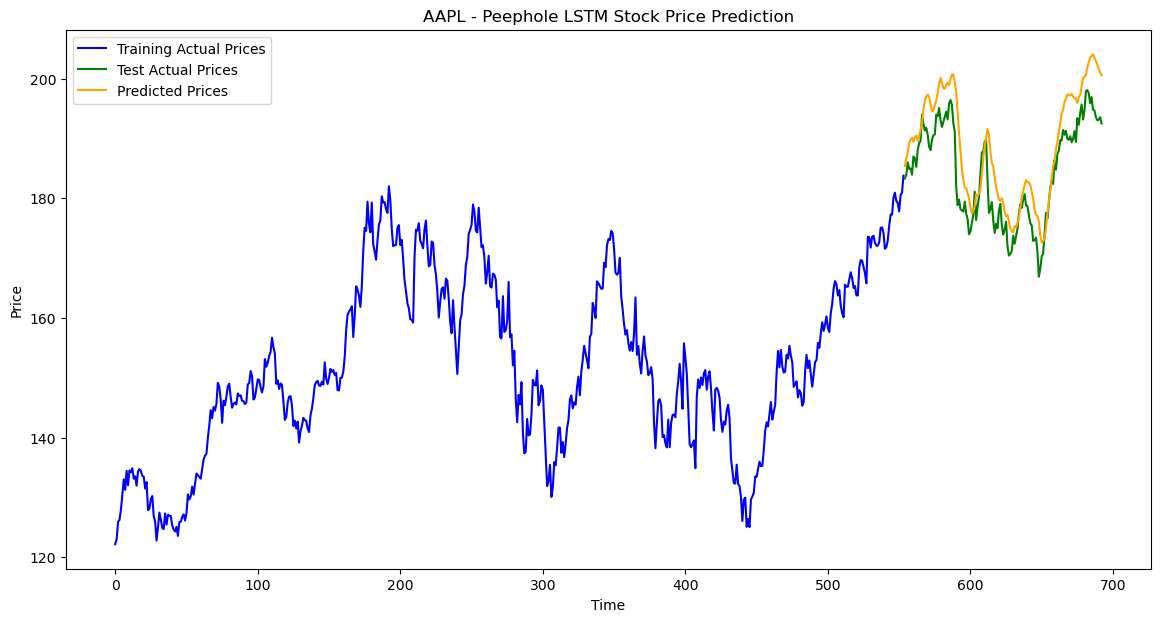

[I 2024-12-18 23:21:11,385] A new study created in memory with name: no-name-ed900802-c576-46eb-8093-96c1587d2d8f


Optimizing Vanilla LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2024-12-18 23:21:23,683] Trial 0 finished with value: 0.5967075950261199 and parameters: {'n_units': 76, 'learning_rate': 3.2871727524634386e-05}. Best is trial 0 with value: 0.5967075950261199.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2024-12-18 23:21:35,252] Trial 1 finished with value: 0.048131460257650575 and parameters: {'n_units': 47, 'learning_rate': 0.0038962576658142507}. Best is trial 1 with value: 0.048131460257650575.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:21:45,448] Trial 2 finished with value: 0.38001327879183816 and parameters: {'n_units': 62, 'learning_rate': 5.209496630512397e-05}. Best is trial 1 with value: 0.048131460257650575.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:21:56,254] Trial 3 finished with value: 0.04135300218044615 and parameters: {'n_units': 79, 'learning_rate': 0.002412119580183159}. Best is trial 3 with value: 0.04135300218044615.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2024-12-18 23:22:05,455] Trial 4 finished with value: 0.07132445059569822 and parameters: {'n_units': 37, 'learning_rate': 0.0025817391281257973}. Best is trial 3 with value: 0.04135300218044615.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2024-12-18 23:22:15,454] Trial 5 finished with value: 0.1563274273029638 and parameters: {'n_units': 50, 'learning_rate': 0.00032855490137301995}. Best is trial 3 with value: 0.04135300218044615.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-18 23:22:24,856] Trial 6 finished with value: 0.41364517305538895 and parameters: {'n_units': 40, 'learning_rate': 7.472408788189847e-05}. Best is trial 3 with value: 0.04135300218044615.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:22:35,388] Trial 7 finished with value: 0.2968838210950172 and parameters: {'n_units': 33, 'learning_rate': 0.00011582392518485725}. Best is trial 3 with value: 0.04135300218044615.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:22:46,613] Trial 8 finished with value: 0.030806394952171974 and parameters: {'n_units': 73, 'learning_rate': 0.007646875289760344}. Best is trial 8 with value: 0.030806394952171974.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2024-12-18 23:22:58,660] Trial 9 finished with value: 0.07018284316949143 and parameters: {'n_units': 38, 'learning_rate': 0.0007833289721308369}. Best is trial 8 with value: 0.030806394952171974.


Best params for Vanilla LSTM: {'n_units': 73, 'learning_rate': 0.007646875289760344}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


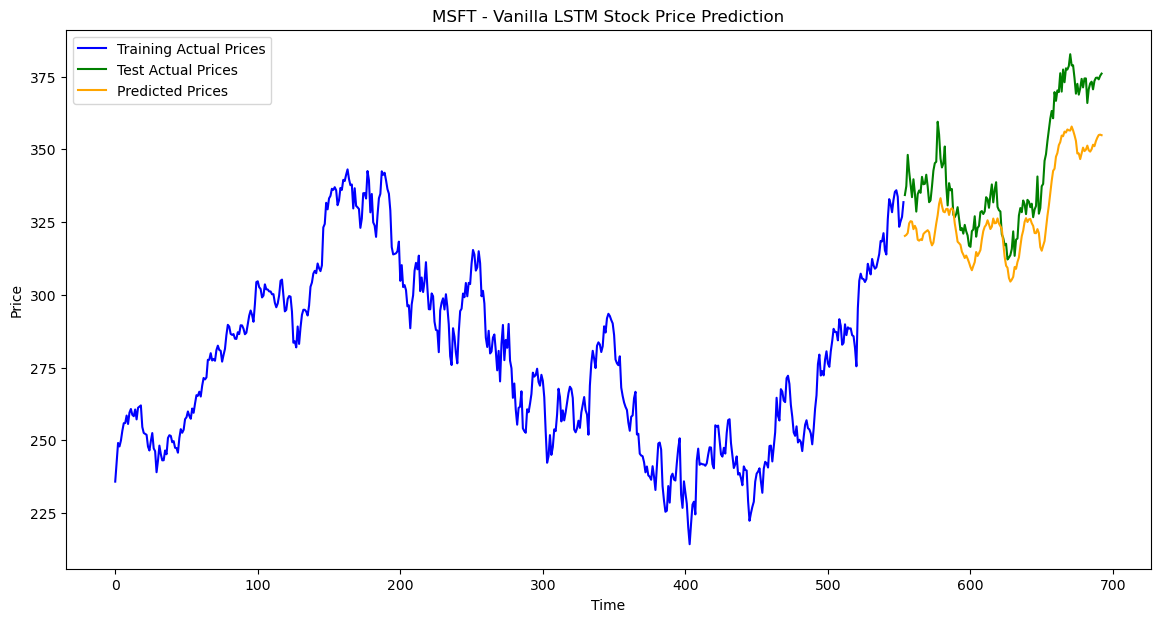

[I 2024-12-18 23:23:08,223] A new study created in memory with name: no-name-e8bb2e68-cc63-4392-b8b4-f727afdee307


Optimizing Stacked LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:23:17,841] Trial 0 finished with value: 0.06327710712059878 and parameters: {'n_units': 30, 'learning_rate': 0.00052424093321149}. Best is trial 0 with value: 0.06327710712059878.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:23:27,198] Trial 1 finished with value: 0.037712014050249605 and parameters: {'n_units': 37, 'learning_rate': 0.0033830993833647103}. Best is trial 1 with value: 0.037712014050249605.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2024-12-18 23:23:35,908] Trial 2 finished with value: 0.19382957869696651 and parameters: {'n_units': 14, 'learning_rate': 0.0008124666083489772}. Best is trial 1 with value: 0.037712014050249605.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


[I 2024-12-18 23:23:47,949] Trial 3 finished with value: 0.03487390074119204 and parameters: {'n_units': 67, 'learning_rate': 0.0074543311217688335}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


[I 2024-12-18 23:23:59,984] Trial 4 finished with value: 0.334708022763793 and parameters: {'n_units': 78, 'learning_rate': 4.312140389268152e-05}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2024-12-18 23:24:11,768] Trial 5 finished with value: 0.7328502993290007 and parameters: {'n_units': 89, 'learning_rate': 1.1509211951767492e-05}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:24:27,166] Trial 6 finished with value: 0.25169501552294643 and parameters: {'n_units': 93, 'learning_rate': 6.506297623670565e-05}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2024-12-18 23:24:39,224] Trial 7 finished with value: 0.6097340086594548 and parameters: {'n_units': 46, 'learning_rate': 3.549524708962063e-05}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2024-12-18 23:24:53,357] Trial 8 finished with value: 0.5544652700354115 and parameters: {'n_units': 100, 'learning_rate': 1.660434147949234e-05}. Best is trial 3 with value: 0.03487390074119204.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2024-12-18 23:25:03,876] Trial 9 finished with value: 0.04818969925846746 and parameters: {'n_units': 31, 'learning_rate': 0.004402008592172203}. Best is trial 3 with value: 0.03487390074119204.


Best params for Stacked LSTM: {'n_units': 67, 'learning_rate': 0.0074543311217688335}
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


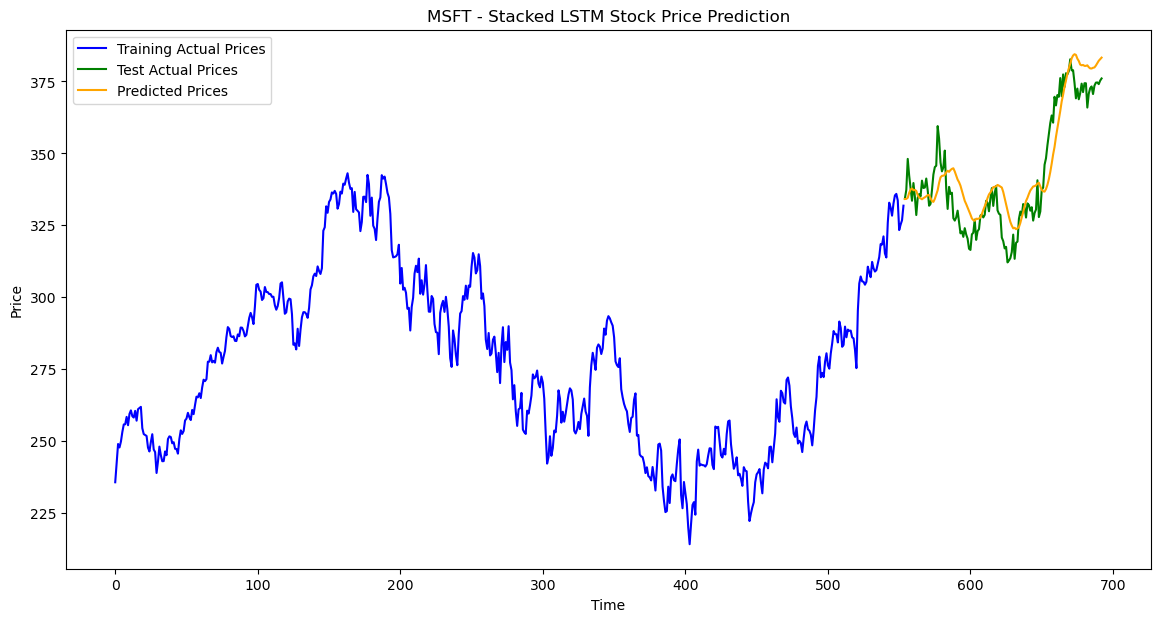

[I 2024-12-18 23:25:22,100] A new study created in memory with name: no-name-dd2e8c6f-4c1e-429b-9418-92951005a209


Optimizing Bidirectional LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


[I 2024-12-18 23:25:31,732] Trial 0 finished with value: 0.03655445972356618 and parameters: {'n_units': 18, 'learning_rate': 0.00827715991869922}. Best is trial 0 with value: 0.03655445972356618.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-18 23:25:43,308] Trial 1 finished with value: 0.2157134825395362 and parameters: {'n_units': 87, 'learning_rate': 7.477812647810786e-05}. Best is trial 0 with value: 0.03655445972356618.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:25:54,897] Trial 2 finished with value: 0.05924608252459649 and parameters: {'n_units': 21, 'learning_rate': 0.0007143112749625856}. Best is trial 0 with value: 0.03655445972356618.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:26:08,819] Trial 3 finished with value: 0.036055447527877184 and parameters: {'n_units': 94, 'learning_rate': 0.003769145239825153}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2024-12-18 23:26:19,862] Trial 4 finished with value: 0.07568655627324083 and parameters: {'n_units': 34, 'learning_rate': 0.00046614133501796866}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


[I 2024-12-18 23:26:36,800] Trial 5 finished with value: 0.11732847795104473 and parameters: {'n_units': 58, 'learning_rate': 0.00032430638834971627}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2024-12-18 23:26:50,176] Trial 6 finished with value: 0.058079131721453126 and parameters: {'n_units': 92, 'learning_rate': 0.0008873957127944294}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:27:05,082] Trial 7 finished with value: 0.053642141589153 and parameters: {'n_units': 96, 'learning_rate': 0.0005794870196840781}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-18 23:27:16,068] Trial 8 finished with value: 0.622710792297897 and parameters: {'n_units': 35, 'learning_rate': 1.8786920980118008e-05}. Best is trial 3 with value: 0.036055447527877184.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-18 23:27:25,005] Trial 9 finished with value: 0.4923096481417005 and parameters: {'n_units': 19, 'learning_rate': 6.777893719435054e-05}. Best is trial 3 with value: 0.036055447527877184.


Best params for Bidirectional LSTM: {'n_units': 94, 'learning_rate': 0.003769145239825153}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


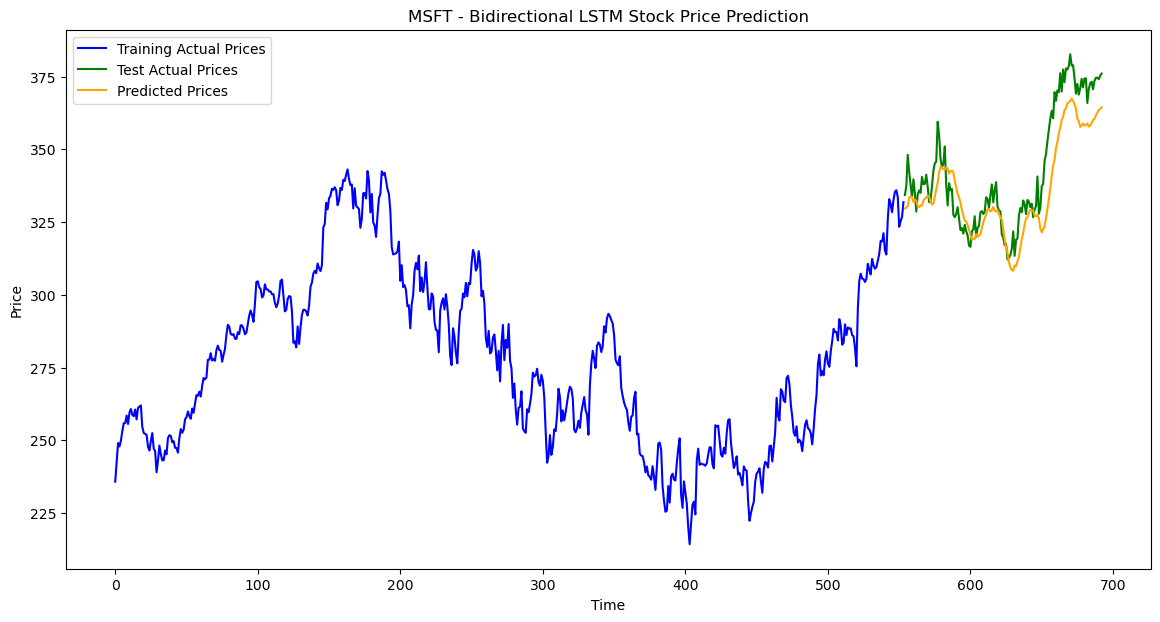

[I 2024-12-18 23:27:37,867] A new study created in memory with name: no-name-7cb18fb7-43af-4250-ba7a-4b9985f74e36


Optimizing CNN-LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:27:48,256] Trial 0 finished with value: 0.2503115399387442 and parameters: {'n_units': 63, 'learning_rate': 6.113480336338814e-05}. Best is trial 0 with value: 0.2503115399387442.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2024-12-18 23:27:59,860] Trial 1 finished with value: 0.03242063524855298 and parameters: {'n_units': 81, 'learning_rate': 0.0056195453564244855}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2024-12-18 23:28:08,176] Trial 2 finished with value: 0.06164933081968195 and parameters: {'n_units': 11, 'learning_rate': 0.001500610844019872}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:28:17,769] Trial 3 finished with value: 0.04129245136273768 and parameters: {'n_units': 35, 'learning_rate': 0.0008441377801402502}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:28:26,551] Trial 4 finished with value: 0.5879231219018884 and parameters: {'n_units': 56, 'learning_rate': 2.0115813681171662e-05}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


[I 2024-12-18 23:28:42,288] Trial 5 finished with value: 0.6862283345674255 and parameters: {'n_units': 100, 'learning_rate': 1.0062351655671983e-05}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2024-12-18 23:28:54,912] Trial 6 finished with value: 0.37753049531261745 and parameters: {'n_units': 99, 'learning_rate': 1.2908924969106028e-05}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:29:06,348] Trial 7 finished with value: 0.054191655370350963 and parameters: {'n_units': 43, 'learning_rate': 0.0038417293515982634}. Best is trial 1 with value: 0.03242063524855298.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:29:18,343] Trial 8 finished with value: 0.03090130520565193 and parameters: {'n_units': 64, 'learning_rate': 0.005595243531062771}. Best is trial 8 with value: 0.03090130520565193.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2024-12-18 23:29:30,593] Trial 9 finished with value: 0.05858884887221598 and parameters: {'n_units': 58, 'learning_rate': 0.000878584756912733}. Best is trial 8 with value: 0.03090130520565193.


Best params for CNN-LSTM: {'n_units': 64, 'learning_rate': 0.005595243531062771}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


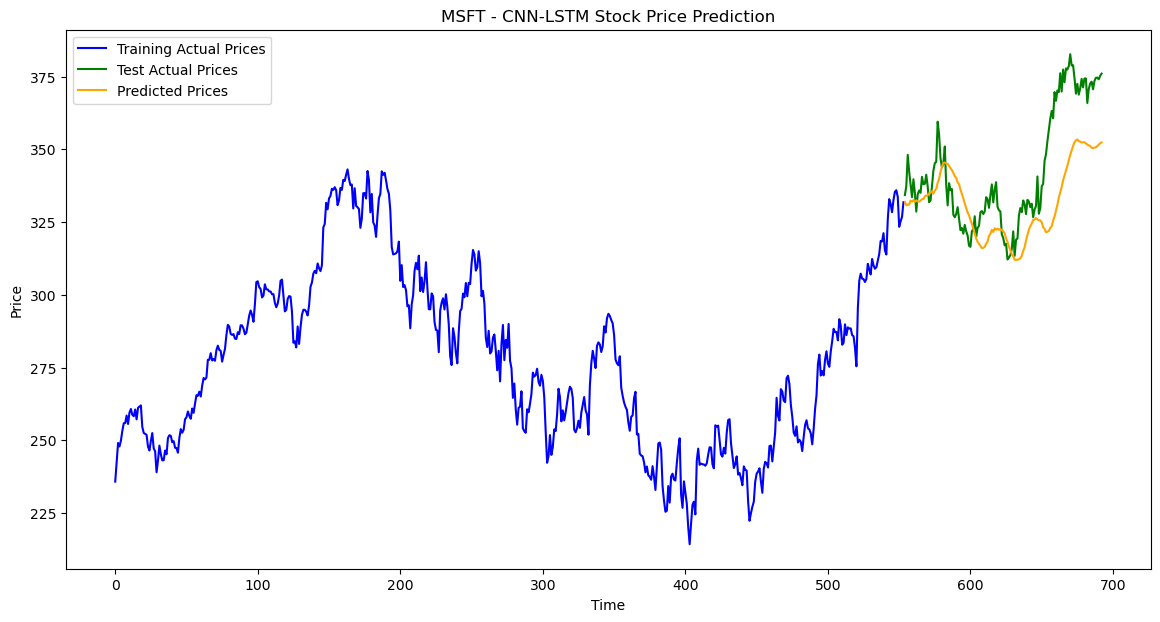

[I 2024-12-18 23:29:38,574] A new study created in memory with name: no-name-12272ef2-ccc7-4f8e-92c1-71d94f9f305a


Optimizing Peephole LSTM for MSFT...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2024-12-18 23:29:48,570] Trial 0 finished with value: 0.6908113063289802 and parameters: {'n_units': 47, 'learning_rate': 1.2781781934389227e-05}. Best is trial 0 with value: 0.6908113063289802.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:30:01,474] Trial 1 finished with value: 0.49357728884764857 and parameters: {'n_units': 90, 'learning_rate': 2.872531872019638e-05}. Best is trial 1 with value: 0.49357728884764857.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:30:12,123] Trial 2 finished with value: 0.07066495104749292 and parameters: {'n_units': 16, 'learning_rate': 0.0013598647443233262}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2024-12-18 23:30:22,668] Trial 3 finished with value: 0.6535208418394136 and parameters: {'n_units': 72, 'learning_rate': 1.8194932175833728e-05}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2024-12-18 23:30:33,956] Trial 4 finished with value: 0.17762083882453744 and parameters: {'n_units': 84, 'learning_rate': 7.74237628063433e-05}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


[I 2024-12-18 23:30:46,633] Trial 5 finished with value: 0.18714661699063284 and parameters: {'n_units': 60, 'learning_rate': 0.00022652789444290567}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:31:04,033] Trial 6 finished with value: 0.23925291789785852 and parameters: {'n_units': 96, 'learning_rate': 0.00011967254764166828}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2024-12-18 23:31:16,353] Trial 7 finished with value: 0.2240779793094142 and parameters: {'n_units': 82, 'learning_rate': 0.00012360538165115214}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


[I 2024-12-18 23:31:27,941] Trial 8 finished with value: 0.5649351361284348 and parameters: {'n_units': 63, 'learning_rate': 1.703014667830498e-05}. Best is trial 2 with value: 0.07066495104749292.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


[I 2024-12-18 23:31:40,399] Trial 9 finished with value: 0.09380770361747352 and parameters: {'n_units': 62, 'learning_rate': 0.0003556997155449449}. Best is trial 2 with value: 0.07066495104749292.


Best params for Peephole LSTM: {'n_units': 16, 'learning_rate': 0.0013598647443233262}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


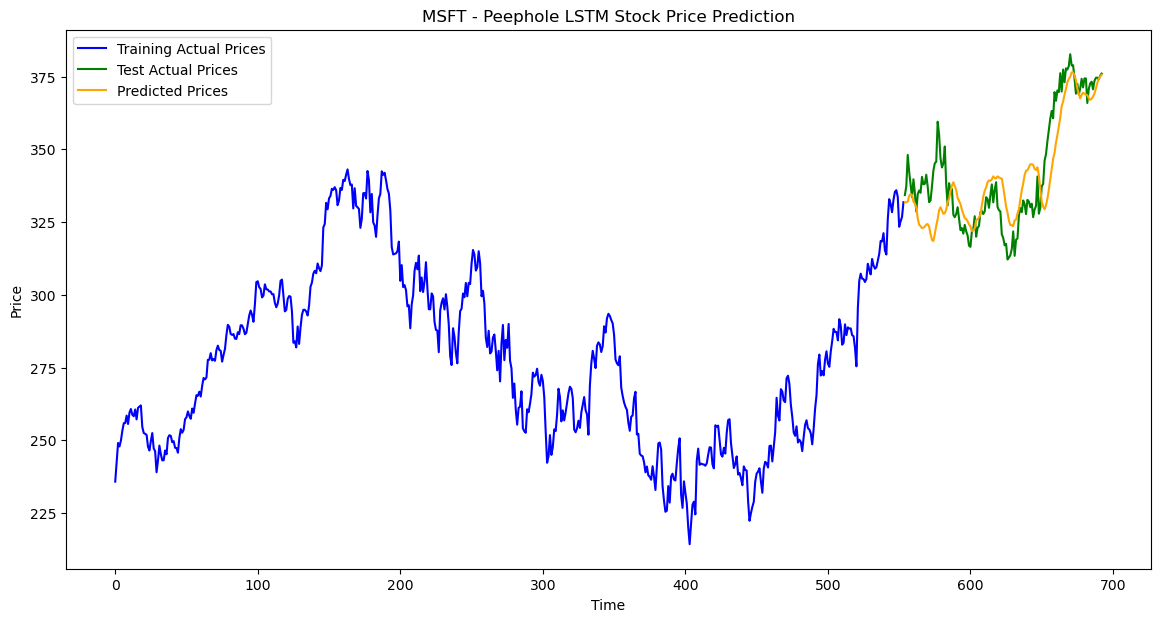

[I 2024-12-18 23:31:53,310] A new study created in memory with name: no-name-fe188c8f-1b45-410e-a385-e3b3de1d100f


Optimizing Vanilla LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2024-12-18 23:32:06,320] Trial 0 finished with value: 0.5537038688202827 and parameters: {'n_units': 88, 'learning_rate': 1.6280699469581295e-05}. Best is trial 0 with value: 0.5537038688202827.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2024-12-18 23:32:17,542] Trial 1 finished with value: 0.6305282303866877 and parameters: {'n_units': 20, 'learning_rate': 5.807496370166134e-05}. Best is trial 0 with value: 0.5537038688202827.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


[I 2024-12-18 23:32:28,742] Trial 2 finished with value: 0.6757567245118064 and parameters: {'n_units': 21, 'learning_rate': 4.46451455111173e-05}. Best is trial 0 with value: 0.5537038688202827.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


[I 2024-12-18 23:32:41,848] Trial 3 finished with value: 0.6747695331405413 and parameters: {'n_units': 60, 'learning_rate': 2.12762529753e-05}. Best is trial 0 with value: 0.5537038688202827.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2024-12-18 23:32:58,201] Trial 4 finished with value: 0.07677522248537644 and parameters: {'n_units': 63, 'learning_rate': 0.00010059381530028486}. Best is trial 4 with value: 0.07677522248537644.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:33:09,526] Trial 5 finished with value: 0.06368083055502534 and parameters: {'n_units': 58, 'learning_rate': 0.0014803353569512873}. Best is trial 5 with value: 0.06368083055502534.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2024-12-18 23:33:18,905] Trial 6 finished with value: 0.18289087523056088 and parameters: {'n_units': 14, 'learning_rate': 0.00036614604094517924}. Best is trial 5 with value: 0.06368083055502534.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


[I 2024-12-18 23:33:32,015] Trial 7 finished with value: 0.07870888361031751 and parameters: {'n_units': 95, 'learning_rate': 8.560861496884001e-05}. Best is trial 5 with value: 0.06368083055502534.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2024-12-18 23:33:44,152] Trial 8 finished with value: 0.06470008415276203 and parameters: {'n_units': 47, 'learning_rate': 0.0003417932910132387}. Best is trial 5 with value: 0.06368083055502534.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2024-12-18 23:33:59,380] Trial 9 finished with value: 0.41569562485303435 and parameters: {'n_units': 64, 'learning_rate': 4.084687037344032e-05}. Best is trial 5 with value: 0.06368083055502534.


Best params for Vanilla LSTM: {'n_units': 58, 'learning_rate': 0.0014803353569512873}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


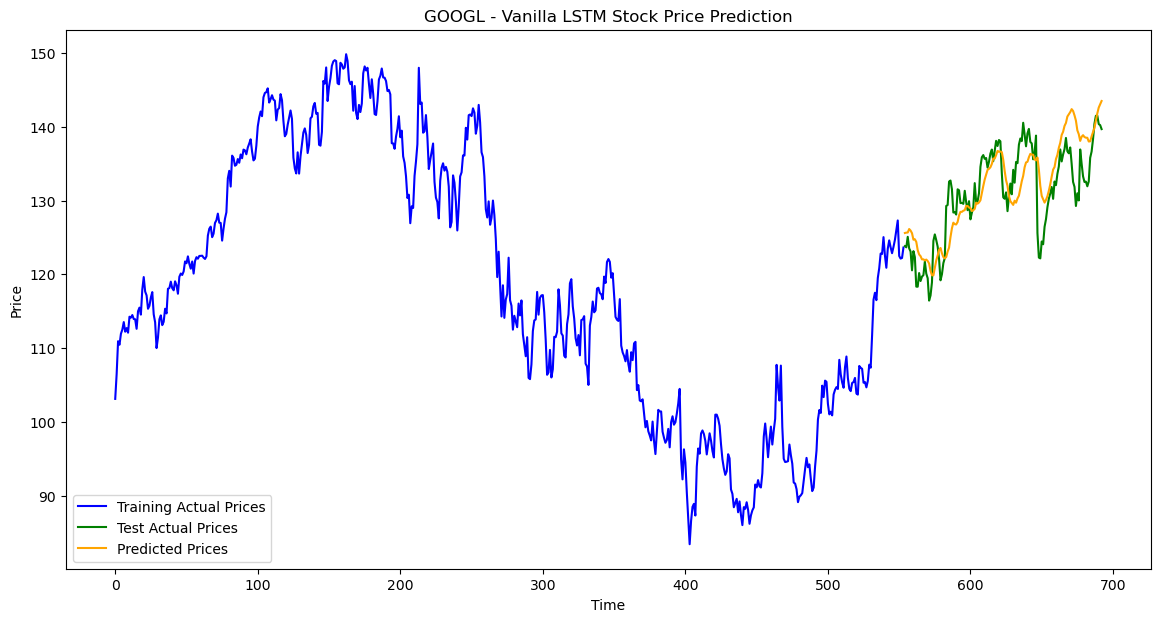

[I 2024-12-18 23:34:08,086] A new study created in memory with name: no-name-e7b4b736-94f3-4ca3-aa84-66248d7b52a5


Optimizing Stacked LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2024-12-18 23:34:18,588] Trial 0 finished with value: 0.06404613345114316 and parameters: {'n_units': 29, 'learning_rate': 0.002451954664390416}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2024-12-18 23:34:32,827] Trial 1 finished with value: 0.07274197340648161 and parameters: {'n_units': 92, 'learning_rate': 0.00027666202639272877}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2024-12-18 23:34:44,216] Trial 2 finished with value: 0.06531014974033775 and parameters: {'n_units': 54, 'learning_rate': 0.0002704597893154555}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2024-12-18 23:34:57,418] Trial 3 finished with value: 0.40744123565220236 and parameters: {'n_units': 91, 'learning_rate': 2.0771372565210282e-05}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


[I 2024-12-18 23:35:08,361] Trial 4 finished with value: 0.08241097317200992 and parameters: {'n_units': 49, 'learning_rate': 0.00016346074757821313}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


[I 2024-12-18 23:35:20,539] Trial 5 finished with value: 0.08999484386346532 and parameters: {'n_units': 22, 'learning_rate': 0.006138186024853598}. Best is trial 0 with value: 0.06404613345114316.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:35:33,209] Trial 6 finished with value: 0.059666237479047986 and parameters: {'n_units': 62, 'learning_rate': 0.0015657065016723543}. Best is trial 6 with value: 0.059666237479047986.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


[I 2024-12-18 23:35:44,539] Trial 7 finished with value: 0.07833050261836118 and parameters: {'n_units': 79, 'learning_rate': 7.054133902328053e-05}. Best is trial 6 with value: 0.059666237479047986.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:35:57,326] Trial 8 finished with value: 0.07019630835128754 and parameters: {'n_units': 75, 'learning_rate': 8.255539470874423e-05}. Best is trial 6 with value: 0.059666237479047986.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


[I 2024-12-18 23:36:09,164] Trial 9 finished with value: 0.0696533265595398 and parameters: {'n_units': 52, 'learning_rate': 0.00039532367172233265}. Best is trial 6 with value: 0.059666237479047986.


Best params for Stacked LSTM: {'n_units': 62, 'learning_rate': 0.0015657065016723543}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


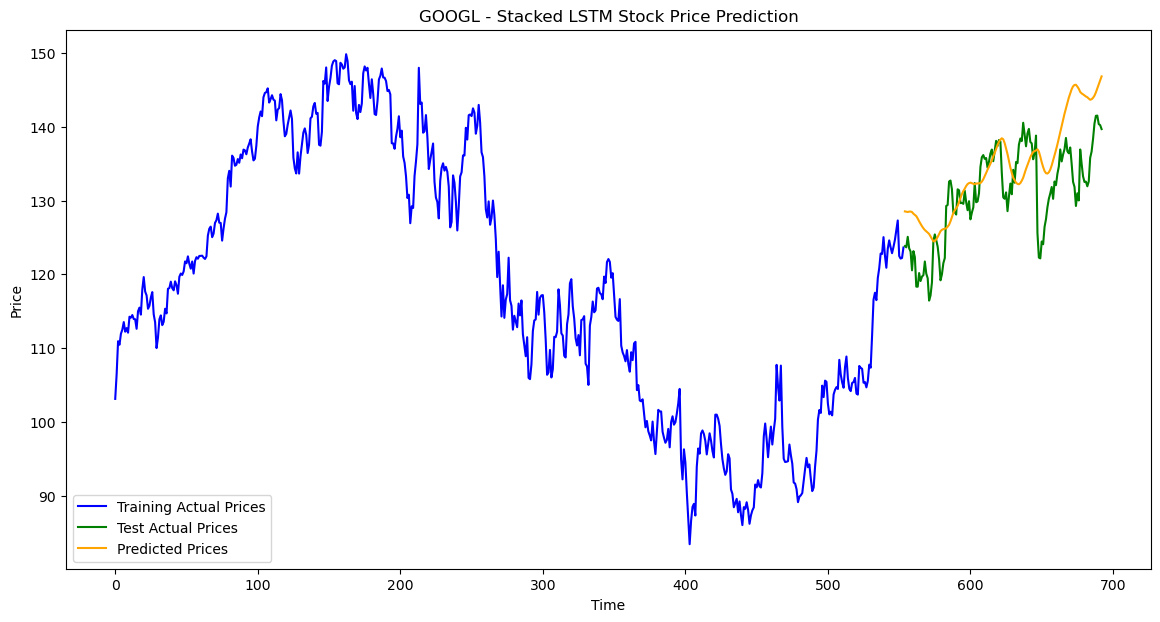

[I 2024-12-18 23:36:27,409] A new study created in memory with name: no-name-62b874b6-7c16-4b36-bcf9-8ab09b676c6d


Optimizing Bidirectional LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


[I 2024-12-18 23:36:39,533] Trial 0 finished with value: 0.3160562294730939 and parameters: {'n_units': 38, 'learning_rate': 6.155536284954715e-05}. Best is trial 0 with value: 0.3160562294730939.


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  


[I 2024-12-18 23:36:58,897] Trial 1 finished with value: 0.07001322346255862 and parameters: {'n_units': 94, 'learning_rate': 0.00011293158138764225}. Best is trial 1 with value: 0.07001322346255862.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2024-12-18 23:37:13,293] Trial 2 finished with value: 0.06203756627898559 and parameters: {'n_units': 95, 'learning_rate': 0.0014816489387479961}. Best is trial 2 with value: 0.06203756627898559.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2024-12-18 23:37:26,041] Trial 3 finished with value: 0.05710042520663049 and parameters: {'n_units': 68, 'learning_rate': 0.0031785494548481185}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-18 23:37:38,802] Trial 4 finished with value: 0.7662905991678216 and parameters: {'n_units': 95, 'learning_rate': 1.0852553440021319e-05}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:37:48,978] Trial 5 finished with value: 0.07204758818829923 and parameters: {'n_units': 19, 'learning_rate': 0.001392309894895133}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2024-12-18 23:38:01,869] Trial 6 finished with value: 0.10341149162416349 and parameters: {'n_units': 15, 'learning_rate': 0.0008775622244582293}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-18 23:38:15,918] Trial 7 finished with value: 0.07021608320248719 and parameters: {'n_units': 99, 'learning_rate': 0.0013524450257320602}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:38:26,178] Trial 8 finished with value: 0.09857965415045088 and parameters: {'n_units': 27, 'learning_rate': 0.000612690069595925}. Best is trial 3 with value: 0.05710042520663049.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


[I 2024-12-18 23:38:38,111] Trial 9 finished with value: 0.08122847201908798 and parameters: {'n_units': 55, 'learning_rate': 0.00027405044601962853}. Best is trial 3 with value: 0.05710042520663049.


Best params for Bidirectional LSTM: {'n_units': 68, 'learning_rate': 0.0031785494548481185}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


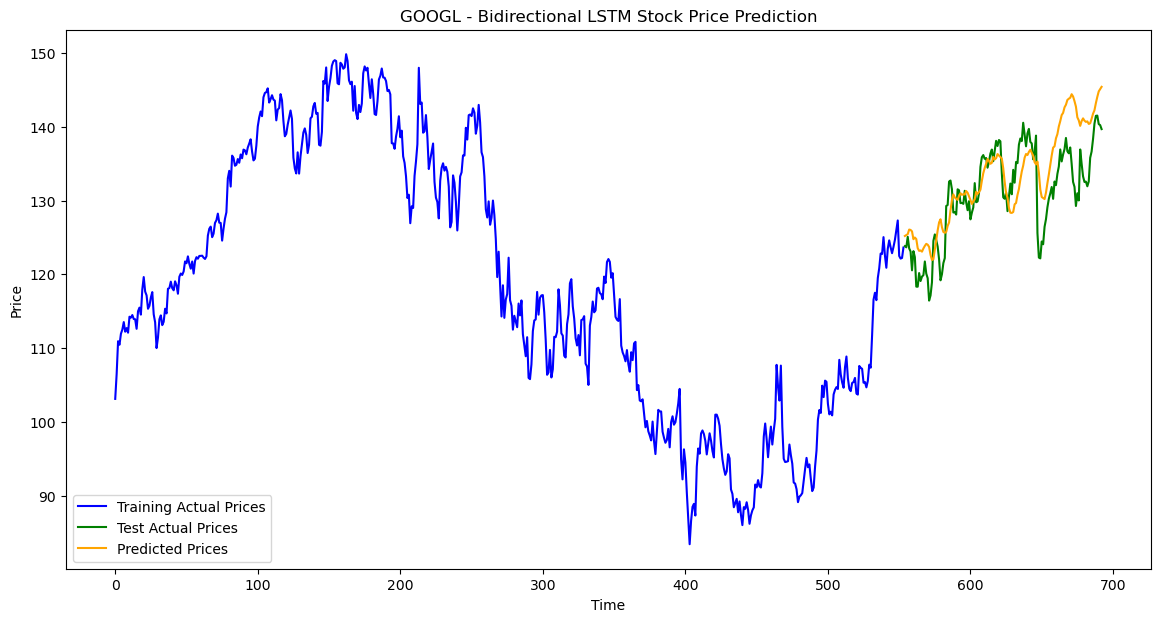

[I 2024-12-18 23:38:50,396] A new study created in memory with name: no-name-9b7aeab4-2b36-44d3-847c-1c70b2133d42


Optimizing CNN-LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


[I 2024-12-18 23:39:02,774] Trial 0 finished with value: 0.25537290133114465 and parameters: {'n_units': 30, 'learning_rate': 0.00012762446841667357}. Best is trial 0 with value: 0.25537290133114465.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2024-12-18 23:39:13,340] Trial 1 finished with value: 0.09688812793080577 and parameters: {'n_units': 44, 'learning_rate': 9.997828325725986e-05}. Best is trial 1 with value: 0.09688812793080577.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2024-12-18 23:39:22,970] Trial 2 finished with value: 0.07957789874606289 and parameters: {'n_units': 26, 'learning_rate': 0.0005892453949592158}. Best is trial 2 with value: 0.07957789874606289.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:39:34,600] Trial 3 finished with value: 0.10635416083201463 and parameters: {'n_units': 27, 'learning_rate': 0.00024255076997635485}. Best is trial 2 with value: 0.07957789874606289.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


[I 2024-12-18 23:39:45,182] Trial 4 finished with value: 0.4633624000180506 and parameters: {'n_units': 46, 'learning_rate': 1.190734409146671e-05}. Best is trial 2 with value: 0.07957789874606289.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


[I 2024-12-18 23:39:56,030] Trial 5 finished with value: 0.05418326390828467 and parameters: {'n_units': 61, 'learning_rate': 0.002792385921390853}. Best is trial 5 with value: 0.05418326390828467.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2024-12-18 23:40:16,713] Trial 6 finished with value: 0.4748462163836111 and parameters: {'n_units': 90, 'learning_rate': 1.3441885415432491e-05}. Best is trial 5 with value: 0.05418326390828467.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


[I 2024-12-18 23:40:27,816] Trial 7 finished with value: 0.3906612060641246 and parameters: {'n_units': 68, 'learning_rate': 2.149677158295506e-05}. Best is trial 5 with value: 0.05418326390828467.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


[I 2024-12-18 23:40:40,240] Trial 8 finished with value: 0.11745643609407233 and parameters: {'n_units': 32, 'learning_rate': 0.00019943069802993638}. Best is trial 5 with value: 0.05418326390828467.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2024-12-18 23:40:52,740] Trial 9 finished with value: 0.11131367299557178 and parameters: {'n_units': 64, 'learning_rate': 0.0011556809817548687}. Best is trial 5 with value: 0.05418326390828467.


Best params for CNN-LSTM: {'n_units': 61, 'learning_rate': 0.002792385921390853}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


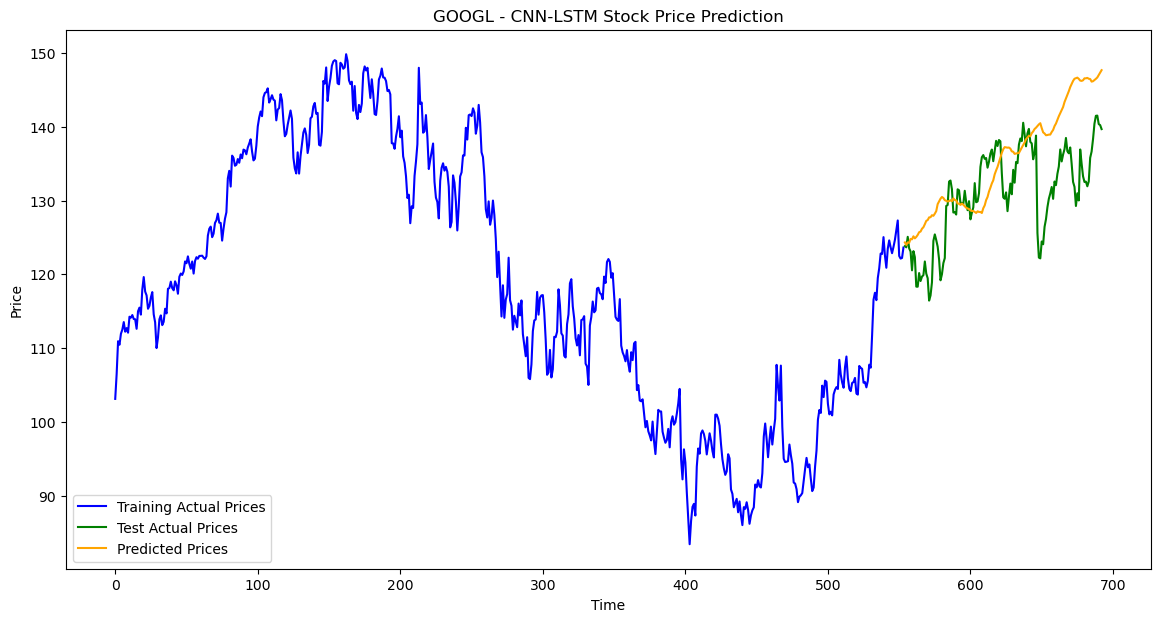

[I 2024-12-18 23:40:59,349] A new study created in memory with name: no-name-bcfd9b1b-abd5-455b-927e-a36583445d54


Optimizing Peephole LSTM for GOOGL...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:41:10,960] Trial 0 finished with value: 0.15077652604036043 and parameters: {'n_units': 25, 'learning_rate': 0.00015029271237389466}. Best is trial 0 with value: 0.15077652604036043.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-18 23:41:22,122] Trial 1 finished with value: 0.7531659334728936 and parameters: {'n_units': 12, 'learning_rate': 1.0822827188539337e-05}. Best is trial 0 with value: 0.15077652604036043.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:41:32,561] Trial 2 finished with value: 0.09111874680790634 and parameters: {'n_units': 11, 'learning_rate': 0.0031637227854352953}. Best is trial 2 with value: 0.09111874680790634.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2024-12-18 23:41:43,131] Trial 3 finished with value: 0.0675806430883085 and parameters: {'n_units': 49, 'learning_rate': 0.0053563612656045406}. Best is trial 3 with value: 0.0675806430883085.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


[I 2024-12-18 23:41:56,341] Trial 4 finished with value: 0.06041388943216283 and parameters: {'n_units': 86, 'learning_rate': 0.0037150437049328043}. Best is trial 4 with value: 0.06041388943216283.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


[I 2024-12-18 23:42:08,821] Trial 5 finished with value: 0.070580255938231 and parameters: {'n_units': 51, 'learning_rate': 0.009315163490139621}. Best is trial 4 with value: 0.06041388943216283.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


[I 2024-12-18 23:42:21,410] Trial 6 finished with value: 0.08153684126410424 and parameters: {'n_units': 81, 'learning_rate': 0.00017318169238374803}. Best is trial 4 with value: 0.06041388943216283.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2024-12-18 23:42:32,860] Trial 7 finished with value: 0.08235249241342453 and parameters: {'n_units': 17, 'learning_rate': 0.0033115990364413106}. Best is trial 4 with value: 0.06041388943216283.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:42:43,364] Trial 8 finished with value: 0.7473212253372 and parameters: {'n_units': 13, 'learning_rate': 9.856518903326983e-05}. Best is trial 4 with value: 0.06041388943216283.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2024-12-18 23:42:54,867] Trial 9 finished with value: 0.06341113734911878 and parameters: {'n_units': 56, 'learning_rate': 0.004430935105834697}. Best is trial 4 with value: 0.06041388943216283.


Best params for Peephole LSTM: {'n_units': 86, 'learning_rate': 0.0037150437049328043}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


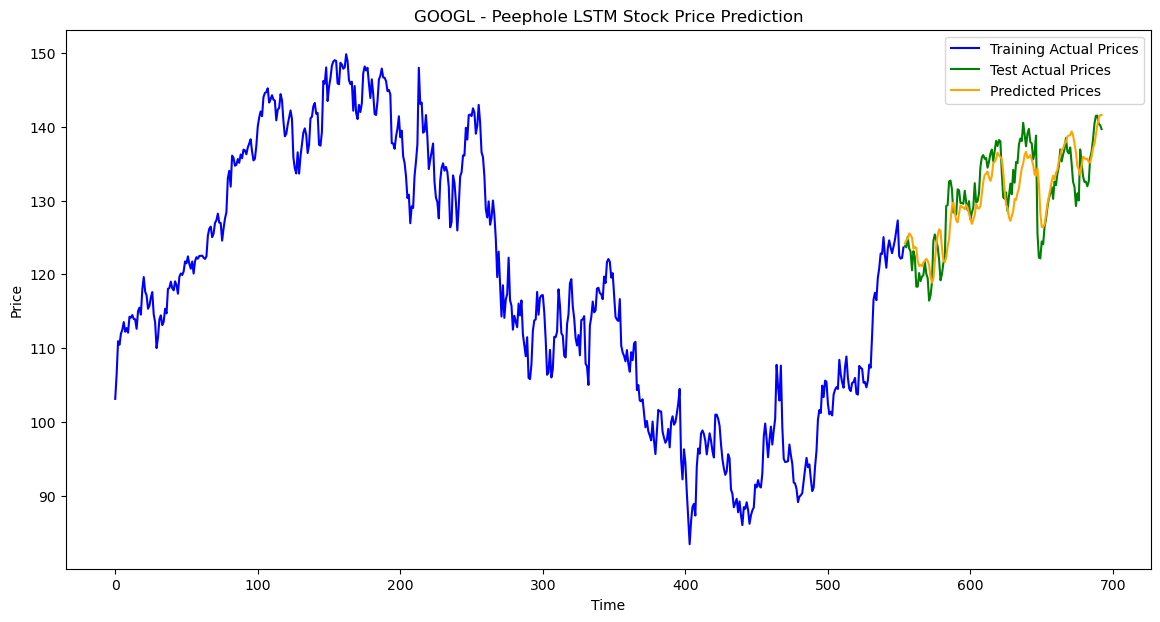

[I 2024-12-18 23:43:07,874] A new study created in memory with name: no-name-72c892d0-f85f-4222-99da-93b86c107677


Optimizing Vanilla LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:43:20,923] Trial 0 finished with value: 0.07537695373915078 and parameters: {'n_units': 81, 'learning_rate': 0.0005673206229666953}. Best is trial 0 with value: 0.07537695373915078.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:43:32,073] Trial 1 finished with value: 0.17932174276944113 and parameters: {'n_units': 43, 'learning_rate': 0.00017682542841374735}. Best is trial 0 with value: 0.07537695373915078.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


[I 2024-12-18 23:43:46,875] Trial 2 finished with value: 0.03879539915365373 and parameters: {'n_units': 26, 'learning_rate': 0.004040068936643103}. Best is trial 2 with value: 0.03879539915365373.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step


[I 2024-12-18 23:44:01,933] Trial 3 finished with value: 0.2882209618029029 and parameters: {'n_units': 81, 'learning_rate': 3.104785339587572e-05}. Best is trial 2 with value: 0.03879539915365373.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2024-12-18 23:44:13,942] Trial 4 finished with value: 0.07444102956118406 and parameters: {'n_units': 43, 'learning_rate': 0.0003443118982379309}. Best is trial 2 with value: 0.03879539915365373.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2024-12-18 23:44:25,679] Trial 5 finished with value: 0.48581289138049844 and parameters: {'n_units': 58, 'learning_rate': 4.0490800572266344e-05}. Best is trial 2 with value: 0.03879539915365373.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:44:39,787] Trial 6 finished with value: 0.03640571930606421 and parameters: {'n_units': 69, 'learning_rate': 0.005527550398939527}. Best is trial 6 with value: 0.03640571930606421.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:44:51,554] Trial 7 finished with value: 0.21886447101978054 and parameters: {'n_units': 69, 'learning_rate': 3.291244638851545e-05}. Best is trial 6 with value: 0.03640571930606421.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


[I 2024-12-18 23:45:02,488] Trial 8 finished with value: 0.06503274129337103 and parameters: {'n_units': 42, 'learning_rate': 6.300491406806765e-05}. Best is trial 6 with value: 0.03640571930606421.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


[I 2024-12-18 23:45:15,682] Trial 9 finished with value: 0.050875762865430156 and parameters: {'n_units': 89, 'learning_rate': 0.001882330997771482}. Best is trial 6 with value: 0.03640571930606421.


Best params for Vanilla LSTM: {'n_units': 69, 'learning_rate': 0.005527550398939527}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


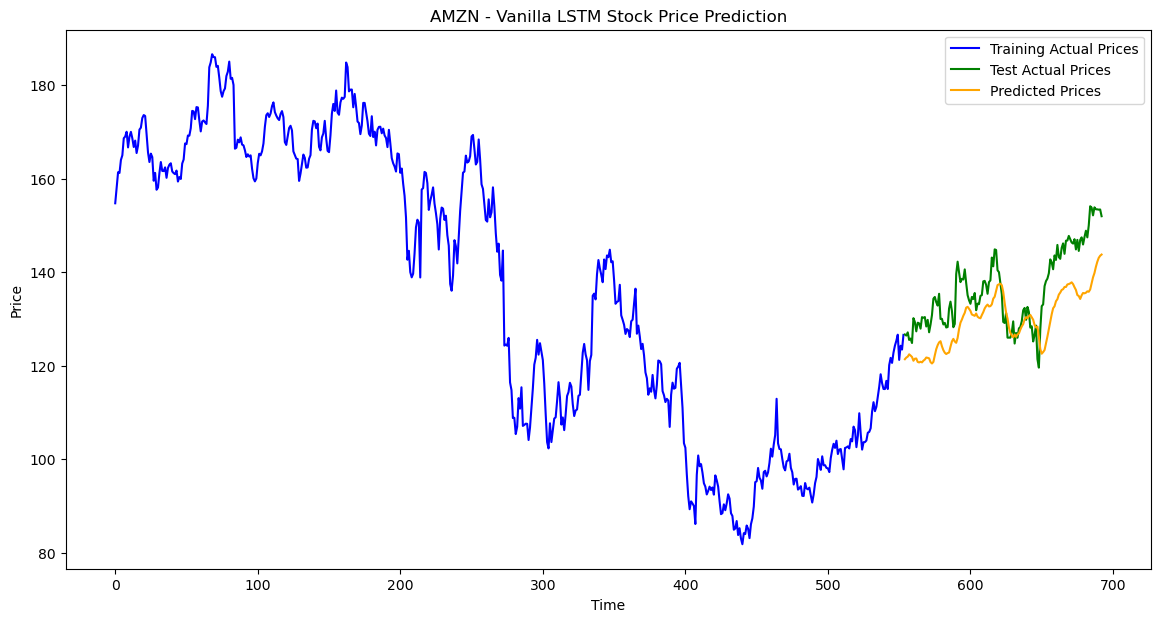

[I 2024-12-18 23:45:25,259] A new study created in memory with name: no-name-ef762ac5-16b4-401d-b577-bb6063f61293


Optimizing Stacked LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


[I 2024-12-18 23:45:36,326] Trial 0 finished with value: 0.07241105685334873 and parameters: {'n_units': 49, 'learning_rate': 0.0006034293507835185}. Best is trial 0 with value: 0.07241105685334873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


[I 2024-12-18 23:45:46,556] Trial 1 finished with value: 0.191039032899342 and parameters: {'n_units': 16, 'learning_rate': 0.00021597142117170797}. Best is trial 0 with value: 0.07241105685334873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2024-12-18 23:45:59,084] Trial 2 finished with value: 0.04037326527012477 and parameters: {'n_units': 86, 'learning_rate': 0.002458595664602909}. Best is trial 2 with value: 0.04037326527012477.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-18 23:46:09,592] Trial 3 finished with value: 0.03650809314141356 and parameters: {'n_units': 33, 'learning_rate': 0.004414180473805678}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:46:19,015] Trial 4 finished with value: 0.04247940756420092 and parameters: {'n_units': 69, 'learning_rate': 0.00852055511509455}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:46:29,931] Trial 5 finished with value: 0.046401667250395434 and parameters: {'n_units': 11, 'learning_rate': 0.0031304135457924077}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


[I 2024-12-18 23:46:41,091] Trial 6 finished with value: 0.054815334486827565 and parameters: {'n_units': 30, 'learning_rate': 0.0025935236917896775}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


[I 2024-12-18 23:46:51,918] Trial 7 finished with value: 0.3087752348712072 and parameters: {'n_units': 24, 'learning_rate': 4.589577782149217e-05}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


[I 2024-12-18 23:47:08,165] Trial 8 finished with value: 0.23551647548551158 and parameters: {'n_units': 68, 'learning_rate': 1.7078683599562456e-05}. Best is trial 3 with value: 0.03650809314141356.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2024-12-18 23:47:20,835] Trial 9 finished with value: 0.04370673906604121 and parameters: {'n_units': 22, 'learning_rate': 0.004272751018862558}. Best is trial 3 with value: 0.03650809314141356.


Best params for Stacked LSTM: {'n_units': 33, 'learning_rate': 0.004414180473805678}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


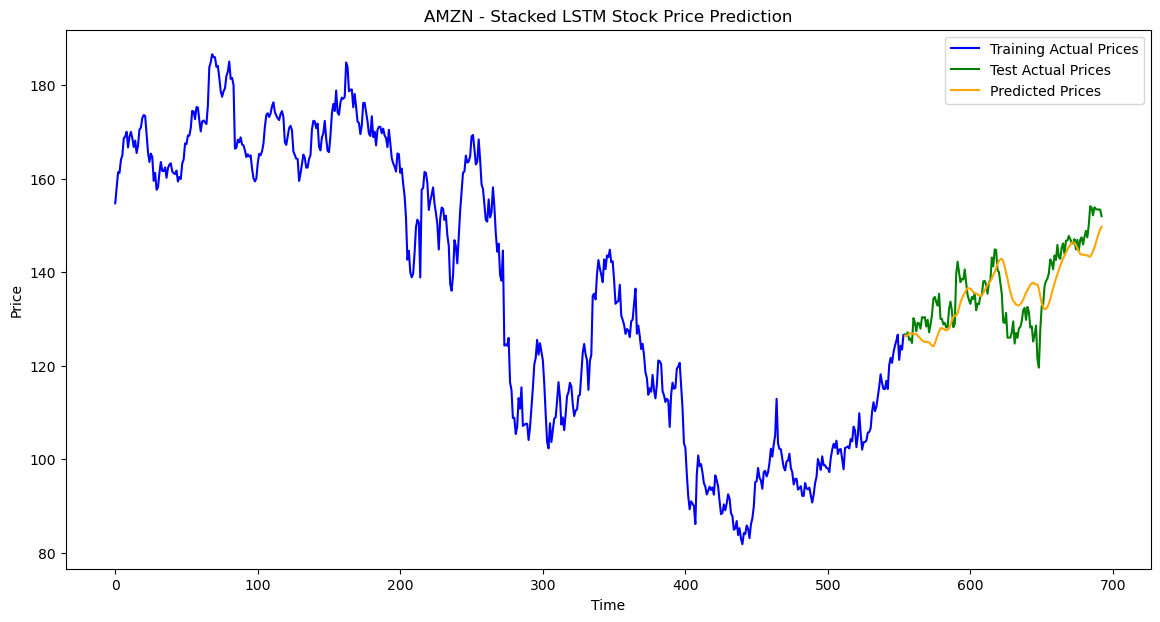

[I 2024-12-18 23:47:38,806] A new study created in memory with name: no-name-c62e11e7-c933-4aa8-9a1e-8a8b3a3fd3b3


Optimizing Bidirectional LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[I 2024-12-18 23:47:48,475] Trial 0 finished with value: 0.2014349216387791 and parameters: {'n_units': 24, 'learning_rate': 0.0003336073445004987}. Best is trial 0 with value: 0.2014349216387791.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:47:58,582] Trial 1 finished with value: 0.10252551839992007 and parameters: {'n_units': 71, 'learning_rate': 0.0002886210180333103}. Best is trial 1 with value: 0.10252551839992007.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2024-12-18 23:48:07,725] Trial 2 finished with value: 0.05769515336651873 and parameters: {'n_units': 35, 'learning_rate': 0.007491688455769138}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-18 23:48:17,464] Trial 3 finished with value: 0.4734348376359089 and parameters: {'n_units': 47, 'learning_rate': 2.287557373418968e-05}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-18 23:48:25,924] Trial 4 finished with value: 0.09301463724105638 and parameters: {'n_units': 34, 'learning_rate': 0.0011412817930939792}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


[I 2024-12-18 23:48:36,374] Trial 5 finished with value: 0.06935302701462627 and parameters: {'n_units': 76, 'learning_rate': 4.4523805261287034e-05}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[I 2024-12-18 23:48:46,051] Trial 6 finished with value: 0.05818691994505805 and parameters: {'n_units': 67, 'learning_rate': 0.0002988927695037263}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2024-12-18 23:48:57,540] Trial 7 finished with value: 0.21590625447383402 and parameters: {'n_units': 69, 'learning_rate': 0.00014853319195988157}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-18 23:49:07,899] Trial 8 finished with value: 0.16894000292722022 and parameters: {'n_units': 50, 'learning_rate': 6.416665096819423e-05}. Best is trial 2 with value: 0.05769515336651873.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:49:17,089] Trial 9 finished with value: 0.07263746806439367 and parameters: {'n_units': 44, 'learning_rate': 5.070390406421877e-05}. Best is trial 2 with value: 0.05769515336651873.


Best params for Bidirectional LSTM: {'n_units': 35, 'learning_rate': 0.007491688455769138}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


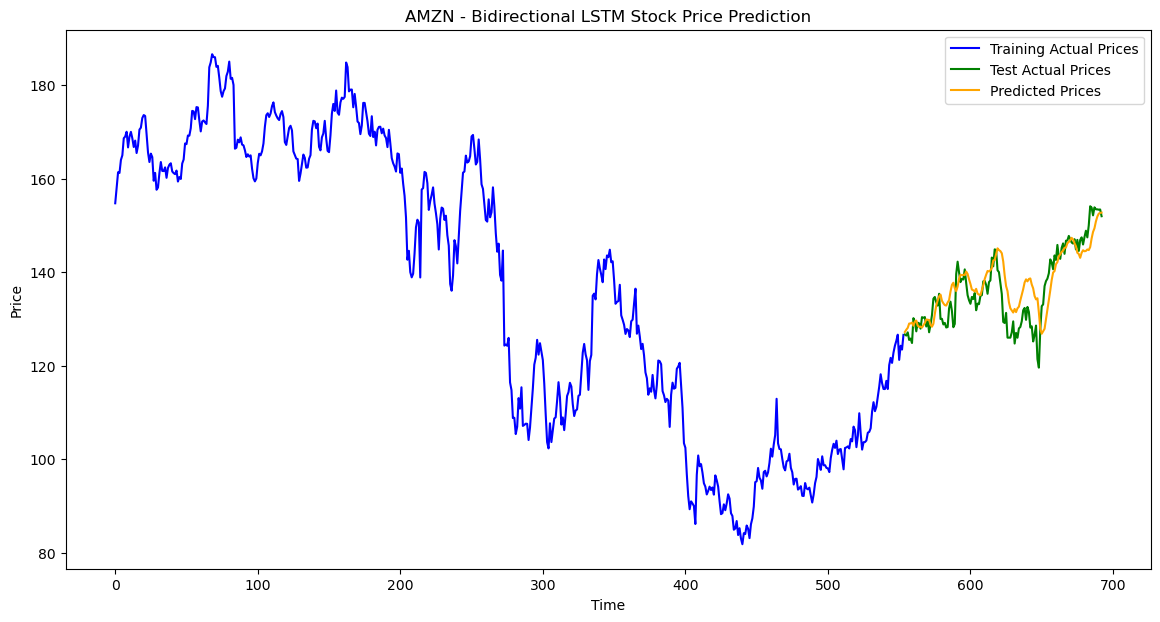

[I 2024-12-18 23:49:28,024] A new study created in memory with name: no-name-a3243dce-4470-4ff5-8c85-00502e6f9512


Optimizing CNN-LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:49:37,463] Trial 0 finished with value: 0.14180365012356114 and parameters: {'n_units': 39, 'learning_rate': 0.0001422176034771474}. Best is trial 0 with value: 0.14180365012356114.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:49:46,818] Trial 1 finished with value: 0.04395279406759376 and parameters: {'n_units': 73, 'learning_rate': 0.0016348821371917626}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2024-12-18 23:49:56,551] Trial 2 finished with value: 0.48851342121129365 and parameters: {'n_units': 30, 'learning_rate': 1.0337187515959596e-05}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[I 2024-12-18 23:50:06,281] Trial 3 finished with value: 0.06048480479519153 and parameters: {'n_units': 51, 'learning_rate': 4.879972138815632e-05}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


[I 2024-12-18 23:50:16,355] Trial 4 finished with value: 0.044168282201042845 and parameters: {'n_units': 64, 'learning_rate': 0.00021277826900751649}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2024-12-18 23:50:31,976] Trial 5 finished with value: 0.07147540226560944 and parameters: {'n_units': 99, 'learning_rate': 0.00031098500859624373}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


[I 2024-12-18 23:50:44,677] Trial 6 finished with value: 0.3746952099557242 and parameters: {'n_units': 45, 'learning_rate': 4.514179617232158e-05}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[I 2024-12-18 23:50:55,150] Trial 7 finished with value: 0.5273868709242142 and parameters: {'n_units': 32, 'learning_rate': 1.9783882108883022e-05}. Best is trial 1 with value: 0.04395279406759376.


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step


[I 2024-12-18 23:51:12,539] Trial 8 finished with value: 0.03801952378607233 and parameters: {'n_units': 81, 'learning_rate': 0.0026218846773920553}. Best is trial 8 with value: 0.03801952378607233.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:51:21,250] Trial 9 finished with value: 0.06626113712479649 and parameters: {'n_units': 39, 'learning_rate': 0.000937008912776883}. Best is trial 8 with value: 0.03801952378607233.


Best params for CNN-LSTM: {'n_units': 81, 'learning_rate': 0.0026218846773920553}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


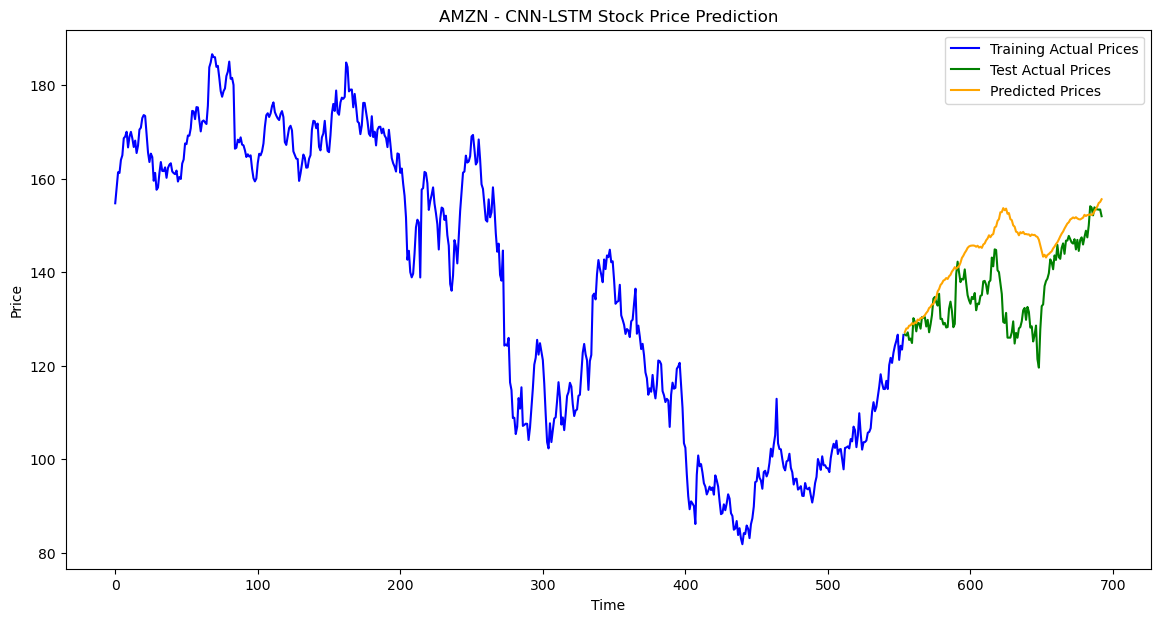

[I 2024-12-18 23:51:27,540] A new study created in memory with name: no-name-ce2fd396-a1a3-4544-bb9b-07b6b2c7686f


Optimizing Peephole LSTM for AMZN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:51:36,366] Trial 0 finished with value: 0.04738385766774431 and parameters: {'n_units': 34, 'learning_rate': 0.002357612201672056}. Best is trial 0 with value: 0.04738385766774431.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-18 23:51:45,862] Trial 1 finished with value: 0.0336327272770259 and parameters: {'n_units': 16, 'learning_rate': 0.009548954241557842}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2024-12-18 23:51:54,186] Trial 2 finished with value: 0.07427111407489492 and parameters: {'n_units': 20, 'learning_rate': 0.00019201595641908217}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-18 23:52:04,311] Trial 3 finished with value: 0.11380442598588253 and parameters: {'n_units': 34, 'learning_rate': 0.0004937669616253167}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:52:14,138] Trial 4 finished with value: 0.318322608997034 and parameters: {'n_units': 13, 'learning_rate': 9.913374705481569e-05}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-18 23:52:23,359] Trial 5 finished with value: 0.05880378953589374 and parameters: {'n_units': 34, 'learning_rate': 0.000526186632922356}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:52:33,589] Trial 6 finished with value: 0.05391954871748816 and parameters: {'n_units': 66, 'learning_rate': 0.00036911992570940215}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-18 23:52:41,857] Trial 7 finished with value: 0.7393008202068367 and parameters: {'n_units': 18, 'learning_rate': 3.820632521808657e-05}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2024-12-18 23:52:52,354] Trial 8 finished with value: 0.19766347191477215 and parameters: {'n_units': 59, 'learning_rate': 8.134503098400954e-05}. Best is trial 1 with value: 0.0336327272770259.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:53:00,807] Trial 9 finished with value: 0.07487152963175357 and parameters: {'n_units': 11, 'learning_rate': 0.00019836759165966396}. Best is trial 1 with value: 0.0336327272770259.


Best params for Peephole LSTM: {'n_units': 16, 'learning_rate': 0.009548954241557842}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


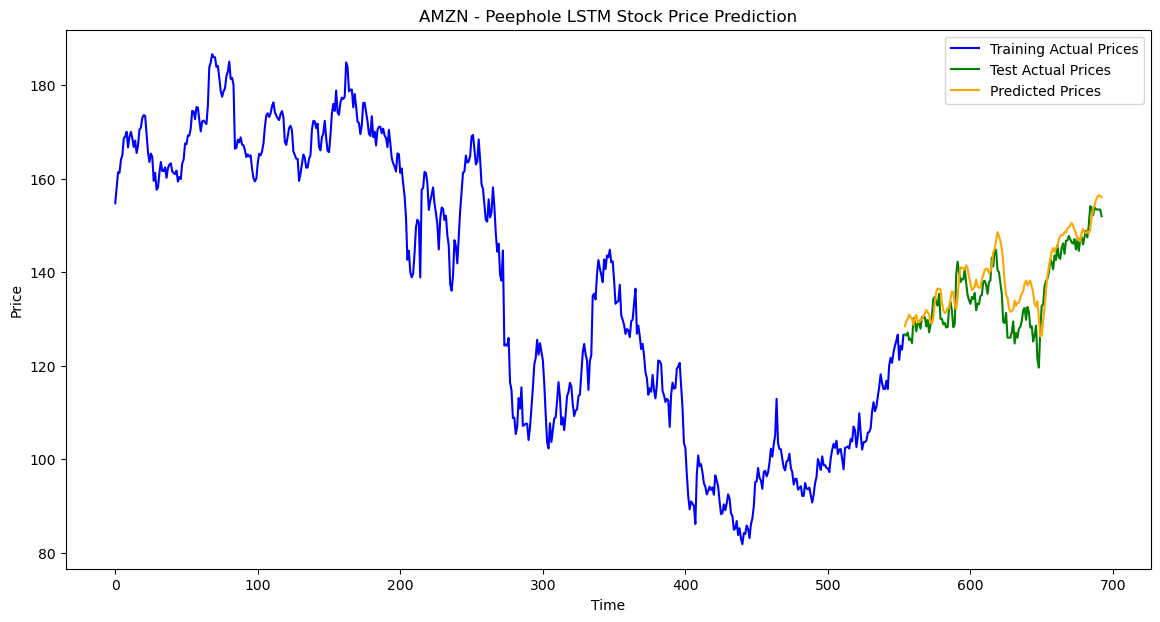

[I 2024-12-18 23:53:09,981] A new study created in memory with name: no-name-fba0f061-b8ed-47a5-b1b2-881a8d4ecd38


Optimizing Vanilla LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2024-12-18 23:53:20,172] Trial 0 finished with value: 0.038198001420051475 and parameters: {'n_units': 62, 'learning_rate': 0.002225624826487387}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:53:30,436] Trial 1 finished with value: 0.045615652103738864 and parameters: {'n_units': 85, 'learning_rate': 0.0020324614844099004}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2024-12-18 23:53:41,723] Trial 2 finished with value: 0.10899579246139027 and parameters: {'n_units': 86, 'learning_rate': 0.0002574070195951715}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:53:52,342] Trial 3 finished with value: 0.057228551304101635 and parameters: {'n_units': 70, 'learning_rate': 0.0004124131057836434}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-18 23:54:02,319] Trial 4 finished with value: 0.1759320012441966 and parameters: {'n_units': 78, 'learning_rate': 6.370813420690624e-05}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-18 23:54:12,423] Trial 5 finished with value: 0.05020221315291324 and parameters: {'n_units': 38, 'learning_rate': 0.0018347810176154269}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2024-12-18 23:54:22,044] Trial 6 finished with value: 0.044342474207206536 and parameters: {'n_units': 35, 'learning_rate': 0.0008607792075215396}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-18 23:54:31,763] Trial 7 finished with value: 0.03967590381643211 and parameters: {'n_units': 50, 'learning_rate': 0.0021316159665411773}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:54:40,964] Trial 8 finished with value: 0.05567222784495157 and parameters: {'n_units': 24, 'learning_rate': 0.0004915583195506186}. Best is trial 0 with value: 0.038198001420051475.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-18 23:54:56,236] Trial 9 finished with value: 0.10048604460908664 and parameters: {'n_units': 22, 'learning_rate': 0.0005653156704595321}. Best is trial 0 with value: 0.038198001420051475.


Best params for Vanilla LSTM: {'n_units': 62, 'learning_rate': 0.002225624826487387}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


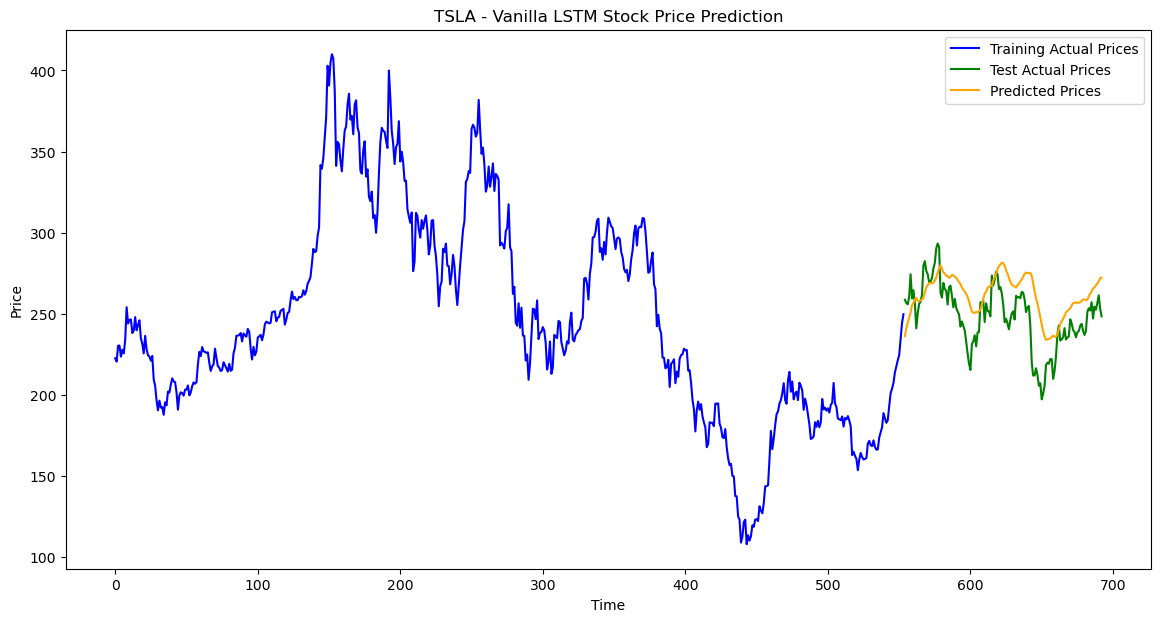

[I 2024-12-18 23:55:03,683] A new study created in memory with name: no-name-69db7d20-3084-49ff-a600-12c64cf9283d


Optimizing Stacked LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2024-12-18 23:55:15,142] Trial 0 finished with value: 0.03508425641373158 and parameters: {'n_units': 90, 'learning_rate': 0.006775363002697224}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2024-12-18 23:55:25,849] Trial 1 finished with value: 0.04123600548084359 and parameters: {'n_units': 29, 'learning_rate': 0.002888474050282348}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:55:39,552] Trial 2 finished with value: 0.09851297311776527 and parameters: {'n_units': 73, 'learning_rate': 3.183843016354113e-05}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-18 23:55:51,427] Trial 3 finished with value: 0.12908601484109816 and parameters: {'n_units': 16, 'learning_rate': 0.0003754041028239972}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2024-12-18 23:56:01,888] Trial 4 finished with value: 0.04777942605956818 and parameters: {'n_units': 32, 'learning_rate': 0.0012159726707370302}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2024-12-18 23:56:14,468] Trial 5 finished with value: 0.1867812167604273 and parameters: {'n_units': 84, 'learning_rate': 0.00016627684823206096}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


[I 2024-12-18 23:56:24,243] Trial 6 finished with value: 0.2880831975849633 and parameters: {'n_units': 56, 'learning_rate': 3.129598066845504e-05}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2024-12-18 23:56:34,436] Trial 7 finished with value: 0.09913957457237048 and parameters: {'n_units': 44, 'learning_rate': 0.0003896064905688895}. Best is trial 0 with value: 0.03508425641373158.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:56:45,198] Trial 8 finished with value: 0.03401345097528461 and parameters: {'n_units': 74, 'learning_rate': 0.0049761492426356625}. Best is trial 8 with value: 0.03401345097528461.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2024-12-18 23:56:55,481] Trial 9 finished with value: 0.3811484839045278 and parameters: {'n_units': 41, 'learning_rate': 1.3523152382127435e-05}. Best is trial 8 with value: 0.03401345097528461.


Best params for Stacked LSTM: {'n_units': 74, 'learning_rate': 0.0049761492426356625}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


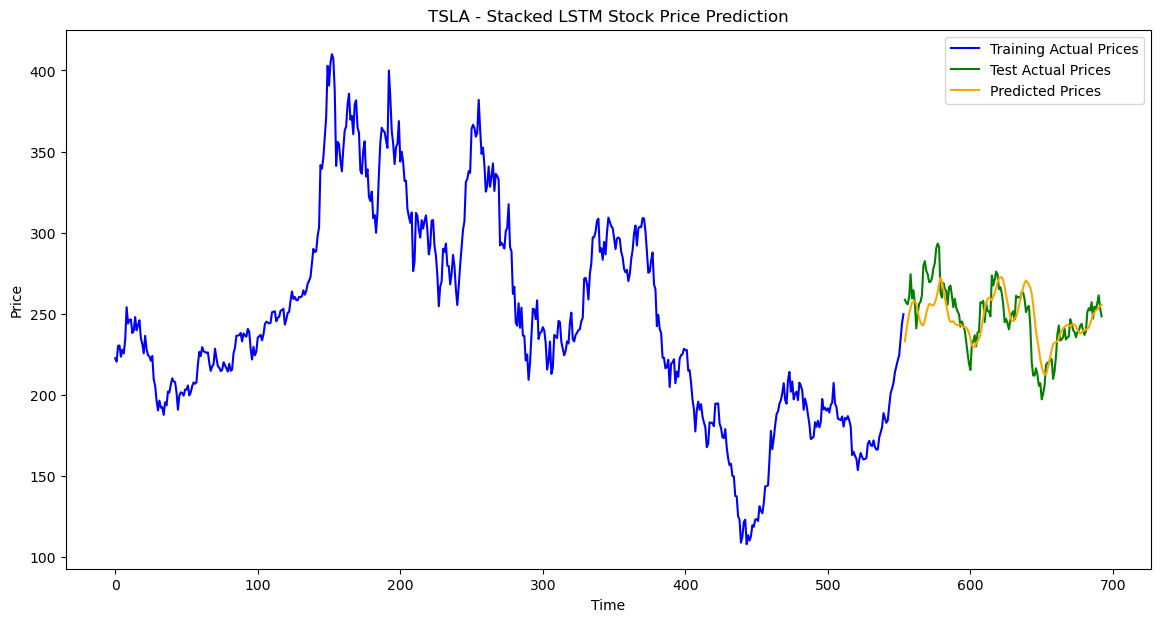

[I 2024-12-18 23:57:12,145] A new study created in memory with name: no-name-b7c1121e-06cf-4c5a-b92c-0b5315e3af3e


Optimizing Bidirectional LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


[I 2024-12-18 23:57:27,356] Trial 0 finished with value: 0.03346631946964877 and parameters: {'n_units': 83, 'learning_rate': 0.0066741292490617304}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2024-12-18 23:57:41,348] Trial 1 finished with value: 0.43482563984335704 and parameters: {'n_units': 18, 'learning_rate': 3.23130258163268e-05}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2024-12-18 23:57:53,482] Trial 2 finished with value: 0.12319807995887701 and parameters: {'n_units': 91, 'learning_rate': 0.0001997863463132918}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:58:02,977] Trial 3 finished with value: 0.13633422573984094 and parameters: {'n_units': 77, 'learning_rate': 0.00023524164976436934}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-18 23:58:12,306] Trial 4 finished with value: 0.133855906652211 and parameters: {'n_units': 13, 'learning_rate': 0.0010758149228933481}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-18 23:58:22,458] Trial 5 finished with value: 0.05466631853179246 and parameters: {'n_units': 91, 'learning_rate': 0.0006980340940523579}. Best is trial 0 with value: 0.03346631946964877.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2024-12-18 23:58:30,425] Trial 6 finished with value: 0.03199206087037723 and parameters: {'n_units': 20, 'learning_rate': 0.0016008555942454952}. Best is trial 6 with value: 0.03199206087037723.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[I 2024-12-18 23:58:39,981] Trial 7 finished with value: 0.039973861891425475 and parameters: {'n_units': 59, 'learning_rate': 0.0026587548305276156}. Best is trial 6 with value: 0.03199206087037723.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:58:48,655] Trial 8 finished with value: 0.1940301039860786 and parameters: {'n_units': 56, 'learning_rate': 0.00018641157886615386}. Best is trial 6 with value: 0.03199206087037723.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2024-12-18 23:58:58,822] Trial 9 finished with value: 0.03276648470624373 and parameters: {'n_units': 74, 'learning_rate': 0.004548473515278076}. Best is trial 6 with value: 0.03199206087037723.


Best params for Bidirectional LSTM: {'n_units': 20, 'learning_rate': 0.0016008555942454952}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


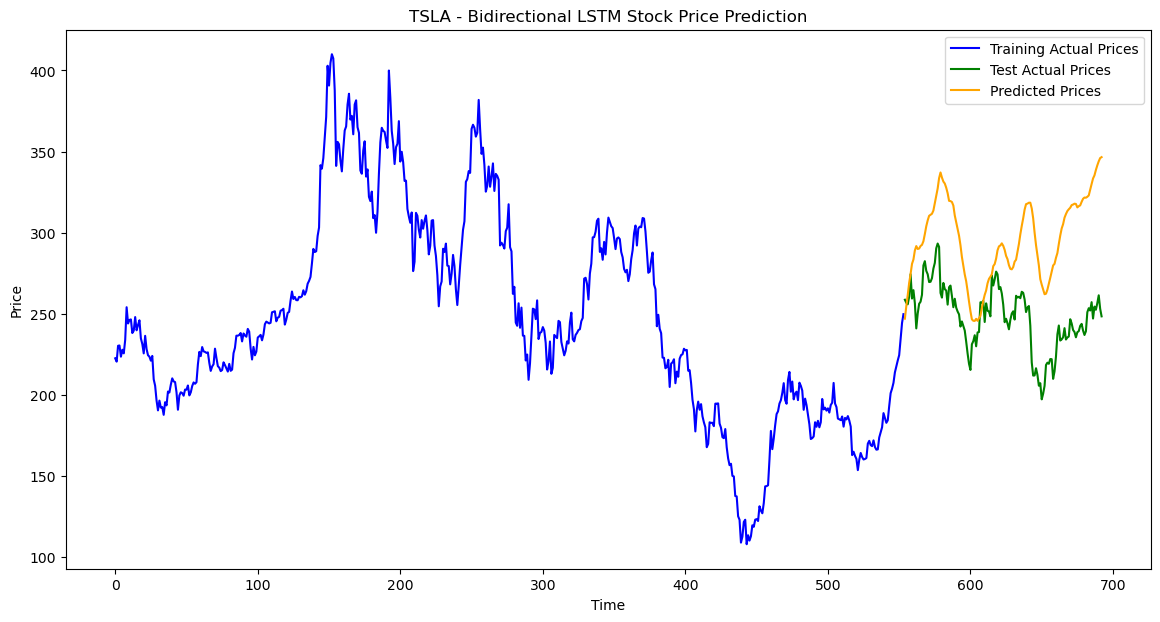

[I 2024-12-18 23:59:08,434] A new study created in memory with name: no-name-6ad4e447-af5c-49e0-8949-342c9199c076


Optimizing CNN-LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-18 23:59:18,401] Trial 0 finished with value: 0.1631960945832416 and parameters: {'n_units': 65, 'learning_rate': 4.3353823532353134e-05}. Best is trial 0 with value: 0.1631960945832416.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-18 23:59:33,363] Trial 1 finished with value: 0.1310753884717272 and parameters: {'n_units': 22, 'learning_rate': 0.0006467196020369878}. Best is trial 1 with value: 0.1310753884717272.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2024-12-18 23:59:44,001] Trial 2 finished with value: 0.04099380977929343 and parameters: {'n_units': 86, 'learning_rate': 0.0020935974212051966}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-18 23:59:53,845] Trial 3 finished with value: 0.2950069503983849 and parameters: {'n_units': 78, 'learning_rate': 3.0436717034689448e-05}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-19 00:00:03,680] Trial 4 finished with value: 0.062468416863628605 and parameters: {'n_units': 13, 'learning_rate': 0.0013519216422414634}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2024-12-19 00:00:12,761] Trial 5 finished with value: 0.17309519795941253 and parameters: {'n_units': 47, 'learning_rate': 0.00022474884764282907}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2024-12-19 00:00:22,609] Trial 6 finished with value: 0.05343956911284841 and parameters: {'n_units': 59, 'learning_rate': 0.0021921614827159633}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-19 00:00:31,890] Trial 7 finished with value: 0.22920201045385571 and parameters: {'n_units': 39, 'learning_rate': 0.00012041594497678227}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-19 00:00:41,874] Trial 8 finished with value: 0.13102960672287933 and parameters: {'n_units': 91, 'learning_rate': 0.00016007164883601974}. Best is trial 2 with value: 0.04099380977929343.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2024-12-19 00:00:51,596] Trial 9 finished with value: 0.11070944132706961 and parameters: {'n_units': 50, 'learning_rate': 0.00021207756134497804}. Best is trial 2 with value: 0.04099380977929343.


Best params for CNN-LSTM: {'n_units': 86, 'learning_rate': 0.0020935974212051966}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


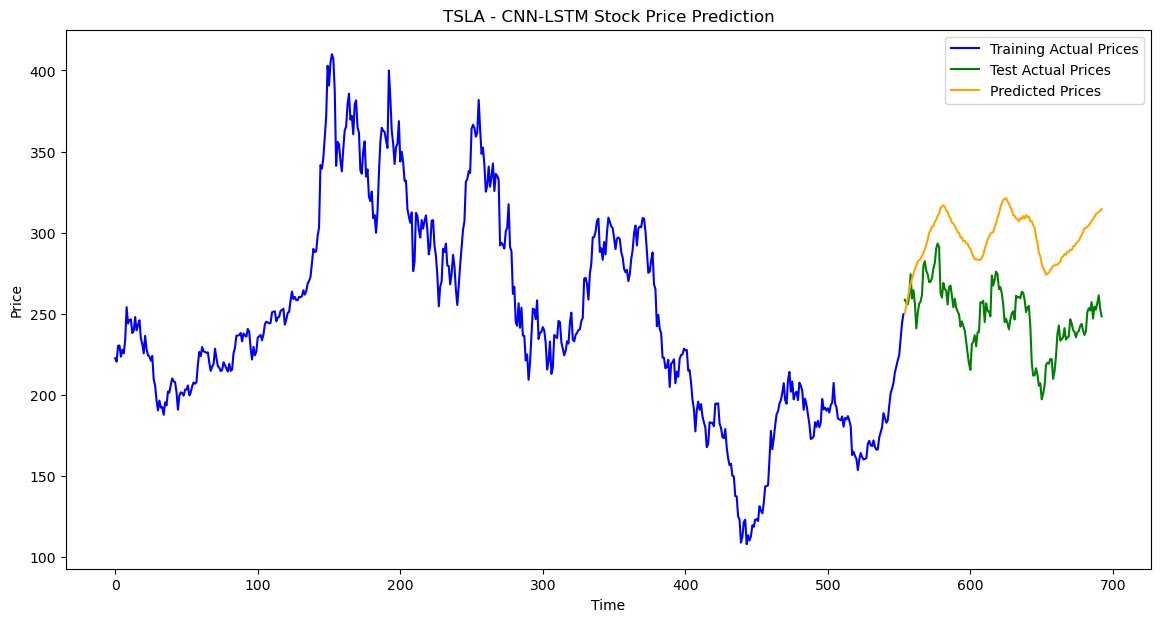

[I 2024-12-19 00:00:56,937] A new study created in memory with name: no-name-3576301f-c003-4b21-a4dc-5c9d18d2ad14


Optimizing Peephole LSTM for TSLA...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-19 00:01:07,134] Trial 0 finished with value: 0.12611740032490504 and parameters: {'n_units': 54, 'learning_rate': 0.00015961062786975467}. Best is trial 0 with value: 0.12611740032490504.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2024-12-19 00:01:16,362] Trial 1 finished with value: 0.1397590025749228 and parameters: {'n_units': 64, 'learning_rate': 0.00011230769199177342}. Best is trial 0 with value: 0.12611740032490504.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-19 00:01:25,472] Trial 2 finished with value: 0.30720452869053555 and parameters: {'n_units': 40, 'learning_rate': 2.8954588729444167e-05}. Best is trial 0 with value: 0.12611740032490504.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2024-12-19 00:01:34,559] Trial 3 finished with value: 0.07273353412539005 and parameters: {'n_units': 45, 'learning_rate': 0.0011650181242912486}. Best is trial 3 with value: 0.07273353412539005.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2024-12-19 00:01:44,419] Trial 4 finished with value: 0.08899208981670825 and parameters: {'n_units': 70, 'learning_rate': 3.9338121597826604e-05}. Best is trial 3 with value: 0.07273353412539005.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-19 00:01:54,335] Trial 5 finished with value: 0.14680593626302457 and parameters: {'n_units': 54, 'learning_rate': 0.00019014974038398624}. Best is trial 3 with value: 0.07273353412539005.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2024-12-19 00:02:02,915] Trial 6 finished with value: 0.45497871348983826 and parameters: {'n_units': 33, 'learning_rate': 2.9377951213451525e-05}. Best is trial 3 with value: 0.07273353412539005.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-19 00:02:13,525] Trial 7 finished with value: 0.04110683944135221 and parameters: {'n_units': 82, 'learning_rate': 0.0022741614284055773}. Best is trial 7 with value: 0.04110683944135221.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


[I 2024-12-19 00:02:24,037] Trial 8 finished with value: 0.03287355233856157 and parameters: {'n_units': 82, 'learning_rate': 0.006867538533182309}. Best is trial 8 with value: 0.03287355233856157.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-19 00:02:33,125] Trial 9 finished with value: 0.33525338970143786 and parameters: {'n_units': 59, 'learning_rate': 1.5580621967890233e-05}. Best is trial 8 with value: 0.03287355233856157.


Best params for Peephole LSTM: {'n_units': 82, 'learning_rate': 0.006867538533182309}
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


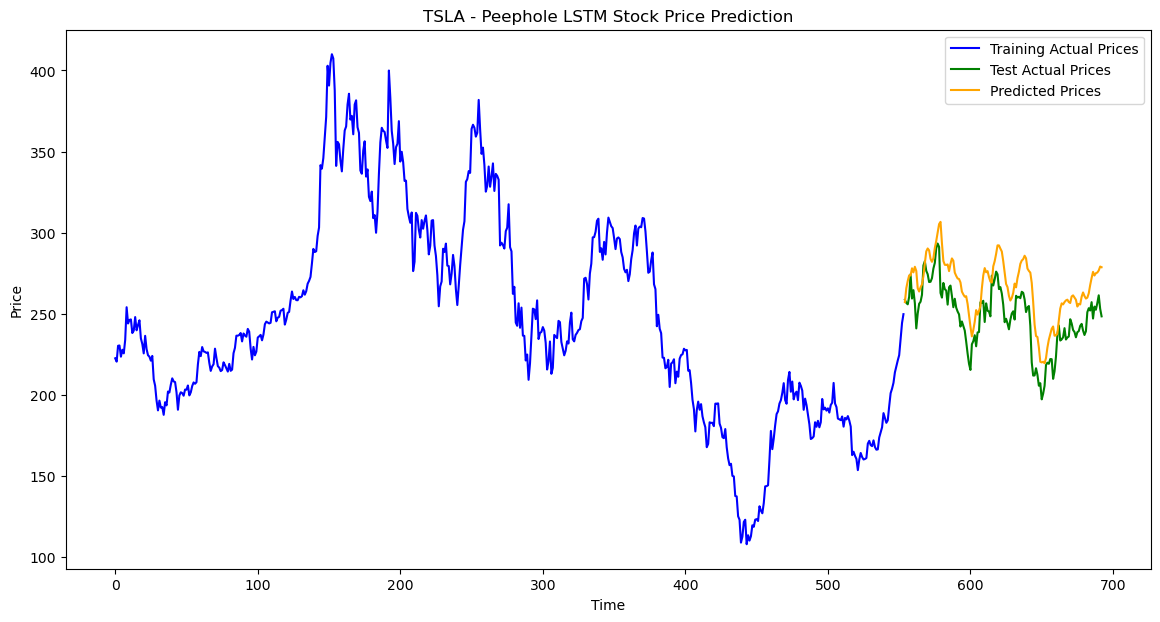

In [54]:
for ticker_idx, stock_name in enumerate(tickers):
    X, y = create_sequences(scaled_data, time_steps, ticker_idx)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(tickers)))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(tickers)))

    models = {
        "Vanilla LSTM": build_vanilla_lstm,
        "Stacked LSTM": build_stacked_lstm,
        "Bidirectional LSTM": build_bidirectional_lstm,
        "CNN-LSTM": build_cnn_lstm,
        "Peephole LSTM": build_peephole_lstm
    }

    stock_results = {}
    for model_name, model_fn in models.items():
        print(f"Optimizing {model_name} for {stock_name}...")
        input_shape = (X_train.shape[1], X_train.shape[2])
        best_params = optimize_model(build_peephole_lstm, X_train, y_train, X_test, y_test, input_shape)

        print(f"Best params for {model_name}: {best_params}")

        # Train model with best parameters
        trial = optuna.trial.FixedTrial(best_params)
        model = model_fn(trial, input_shape)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model
        y_pred, exec_time, rmse, mse, mae = evaluate_model(model, X_test, y_test)
        stock_results[model_name] = {"Execution Time": exec_time, "RMSE": rmse, "MSE": mse, "MAE": mae}

        # Visualize predictions
        plot_predictions(y_train, y_test, y_pred, scaler, stock_name, model_name, ticker_idx)

    # Save results for each stock
    results[stock_name] = pd.DataFrame(stock_results).T
    performance_summary.append({stock_name: results[stock_name]})

## 2.6 Overall performance

In [56]:
# Display performance summary
for stock_name, result_df in results.items():
    print(f"Performance for {stock_name}:")
    print(result_df)

Performance for AAPL:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              0.870335  0.049417  0.002442  0.038947
Stacked LSTM              1.231694  0.119439  0.014266  0.096426
Bidirectional LSTM        1.238507  0.082772  0.006851  0.068987
CNN-LSTM                  0.728576  0.079789  0.006366  0.072688
Peephole LSTM             0.689652  0.068033  0.004629  0.057146
Performance for MSFT:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              1.076241  0.094506  0.008931  0.083748
Stacked LSTM              1.869972  0.053530  0.002865  0.043903
Bidirectional LSTM        1.136698  0.061086  0.003732  0.050202
CNN-LSTM                  0.831905  0.102751  0.010558  0.081023
Peephole LSTM             0.651229  0.065210  0.004252  0.052287
Performance for GOOGL:
                    Execution Time      RMSE       MSE       MAE
Vanilla LSTM              0.748008  0.063103  0.003982  0.049777
Stacked LSTM           